In [21]:
#run this cell
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
%config NotebookApp.iopub_data_rate_limit = 10000000  # Adjust the limit as needed

In [22]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import logging
import time
import sys




In [23]:
#loading the data

solar_data= pd.read_csv("C:/Users/ucbab/Downloads/archive/solar_inverter_measurements_March_2024.csv")
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604799 entries, 0 to 604798
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetimestamp         604799 non-null  object 
 1   datetimestampseconds  604799 non-null  int64  
 2   AphA                  604799 non-null  float64
 3   Hz                    604799 non-null  float64
 4   PF                    604799 non-null  float64
 5   PhVphA                604799 non-null  float64
 6   VA                    604799 non-null  float64
 7   VAr                   604799 non-null  float64
 8   W                     604799 non-null  float64
 9   DCV                   604799 non-null  float64
 10  DCA                   604799 non-null  float64
 11  DCW                   604799 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 55.4+ MB


In [24]:
#converting the date columns to datetime format
solar_data['datetimestamp']= pd.to_datetime(solar_data['datetimestamp'], errors = 'coerce')
solar_data['datetimestampseconds'] = pd.to_datetime(solar_data['datetimestampseconds'], unit = 's')

In [25]:

#removing datetiestamp since datetimestampseconds gives a more comprehensive time
solar_data.rename(columns={'datetimestampseconds': 'timestamp'}, inplace=True)
solar_data.drop(columns=['datetimestamp'], inplace=True)

In [26]:
solar_data.set_index('timestamp', inplace=True)

In [27]:

solar_data

,AphA,Hz,PF,PhVphA,VA,VAr,W,DCV,DCA,DCW
timestamp,,,,,,,,,,
2024-03-17 00:00:00,0.160,59.990,100.0,236.90,18.0,0.0,18.0,262.35,0.16,41.976
2024-03-17 00:00:01,0.160,59.990,100.0,236.90,18.0,0.0,18.0,262.35,0.16,41.976
2024-03-17 00:00:02,0.160,59.990,100.0,236.90,18.0,0.0,18.0,262.35,0.16,41.976
2024-03-17 00:00:03,0.160,59.990,100.0,236.90,21.0,0.0,21.0,269.50,0.12,32.340
2024-03-17 00:00:04,0.155,59.985,100.0,236.95,20.0,0.0,20.0,311.70,0.11,34.287
...,...,...,...,...,...,...,...,...,...,...
2024-03-23 23:59:54,0.250,60.000,100.0,237.20,46.0,0.0,46.0,333.65,0.24,80.076
2024-03-23 23:59:55,0.255,60.000,100.0,237.20,47.0,0.0,47.0,311.15,0.27,84.010
2024-03-23 23:59:56,0.260,60.000,100.0,237.20,48.0,0.0,48.0,311.15,0.27,84.010


In [28]:
#droppimg the power factor column as it is of less correlation
solar_data.drop(columns='PF', inplace=True)

In [29]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604799 entries, 2024-03-17 00:00:00 to 2024-03-23 23:59:58
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AphA    604799 non-null  float64
 1   Hz      604799 non-null  float64
 2   PhVphA  604799 non-null  float64
 3   VA      604799 non-null  float64
 4   VAr     604799 non-null  float64
 5   W       604799 non-null  float64
 6   DCV     604799 non-null  float64
 7   DCA     604799 non-null  float64
 8   DCW     604799 non-null  float64
dtypes: float64(9)
memory usage: 46.1 MB


In [30]:
#normalizing the data
scaler = StandardScaler()
norm_solar_data = scaler.fit_transform(solar_data)

In [31]:

norm_solar_data.shape

(604799, 9)

In [32]:

#creating sequences
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)
seq_length = 5

In [33]:

X = create_sequences(norm_solar_data, seq_length)

In [34]:

X.shape

(604794, 5, 9)

In [35]:

x_train, x_test = train_test_split(X, test_size=0.2, shuffle=False)

In [36]:

feature_index = 6
y_train = x_train[:, :, feature_index]  # shape: (num_samples, num_timesteps)
y_train = np.expand_dims(y_train, axis=-1)


In [37]:

callback = keras.callbacks.EarlyStopping(monitor='loss',patience=4,min_delta= 0.0001, restore_best_weights=True)
input_layer = Input(shape=(seq_length, X.shape[2]))
encoded = LSTM(64, return_sequences=False)(input_layer)
encoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(64, return_sequences=True)(encoded)
decoded = TimeDistributed(Dense((X.shape[2])))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

In [38]:

history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    validation_split = 0.2,
    callbacks = [callback]
)

Epoch 1/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - loss: 0.0352 - val_loss: 0.0011
Epoch 2/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - loss: 5.5139e-04 - val_loss: 6.0172e-04
Epoch 3/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - loss: 3.5227e-04 - val_loss: 4.7676e-04
Epoch 4/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 3.0393e-04 - val_loss: 4.0060e-04
Epoch 5/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 2.8543e-04 - val_loss: 3.4928e-04
Epoch 6/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 2.2609e-04 - val_loss: 2.9842e-04
Epoch 7/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 1.9105e-04 - val_loss: 2.7816e-04
Epoch 8/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 1.6840e-04 - val_loss: 2.2720e-04
Epoch 9/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 1.4291e-04 - val_loss: 2.0803e-04
Epoch 10/50
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - loss: 1.4146e-04 - val_loss: 1.9116e-04


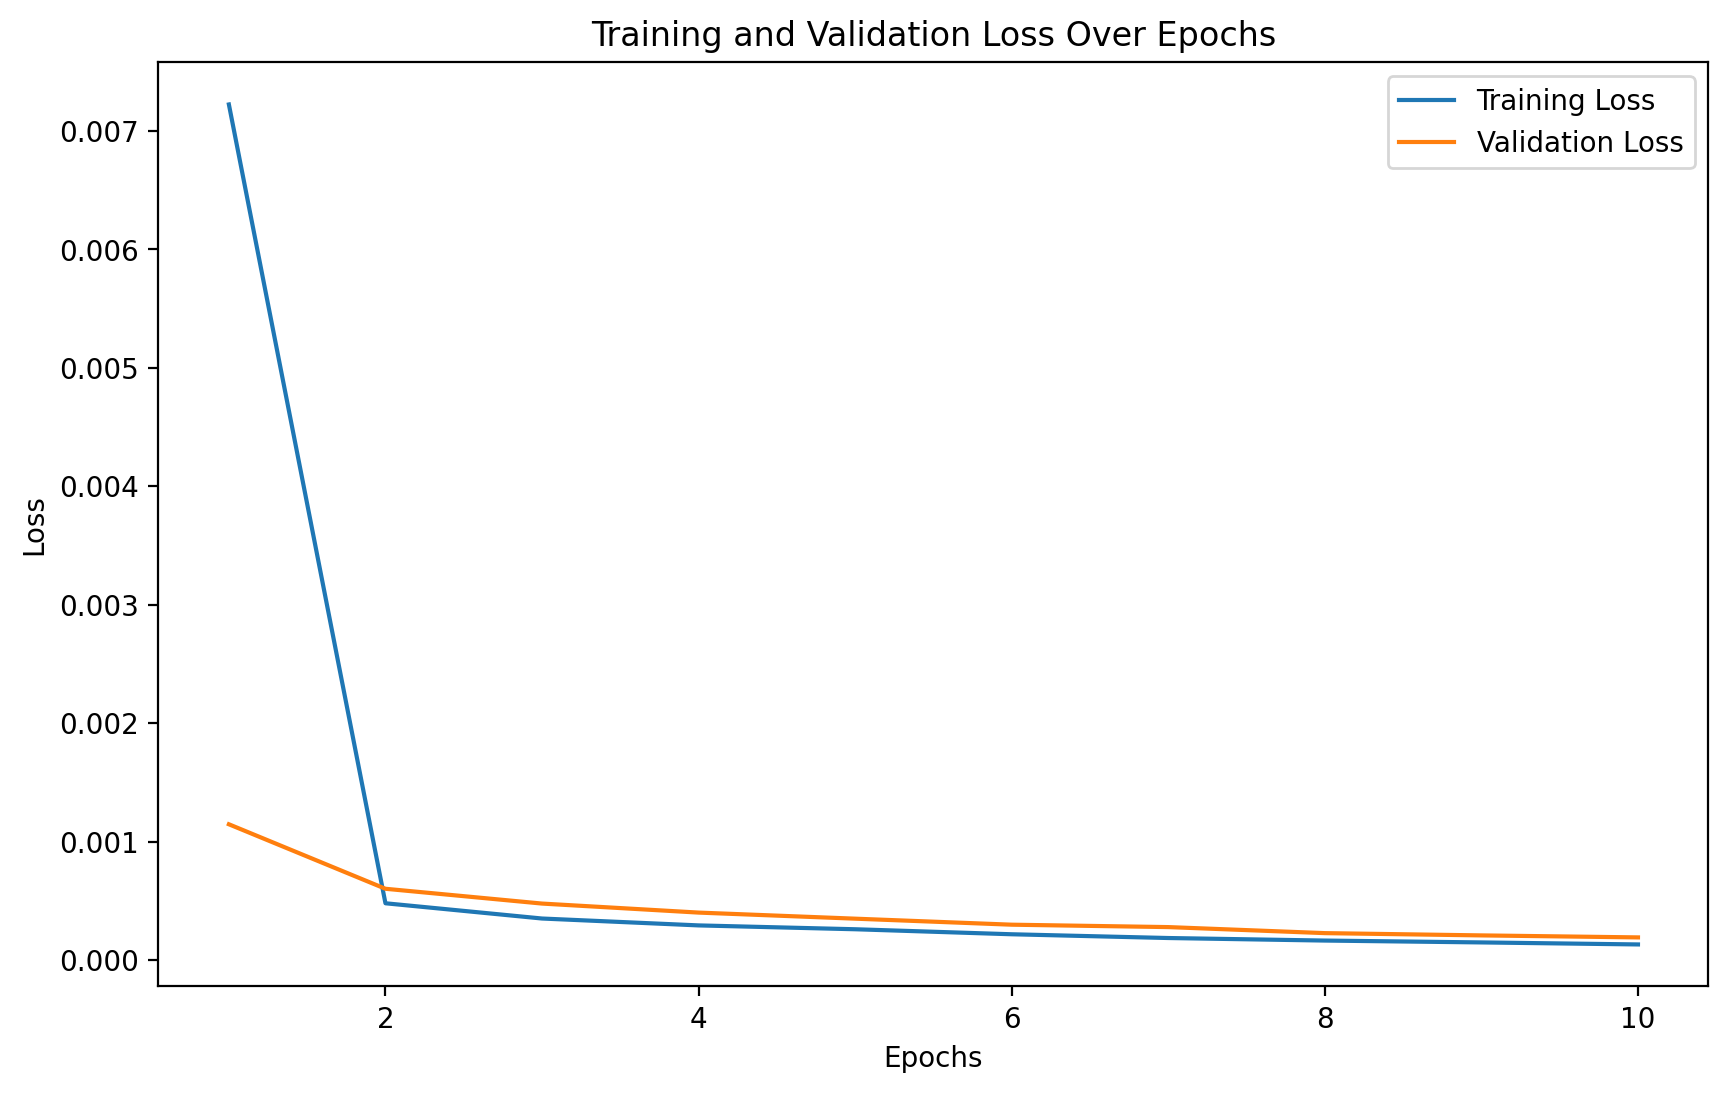

In [39]:

def plot_training_and_validation_loss(history, plot_filename=None):
    """Plot training and validation loss"""
    steps = list(range(1, len(history.history['loss']) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(steps, history.history['loss'], label="Training Loss")
    plt.plot(steps, history.history['val_loss'], label="Validation Loss")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    
    if plot_filename:
        print(f"Saving training and validation loss plot in {plot_filename}...")
        plt.savefig(plot_filename)
    
    plt.show()

# Plot the training and validation loss
plot_training_and_validation_loss(history)


In [40]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 9)           │           585 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,661 (615.87 KB)

 Trainable params: 52,553 (205.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,108 (410.58 KB)

In [41]:
from tensorflow.keras.utils import plot_model

# Plot the LSTM model architecture
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='lstm_model.png')


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [42]:
#calculate reconstructions
reconstructions = autoencoder.predict(X)

18900/18900 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


In [43]:
#check the shape of reconstructions
reconstructions.shape

(604794, 5, 9)

In [44]:

X.shape

(604794, 5, 9)

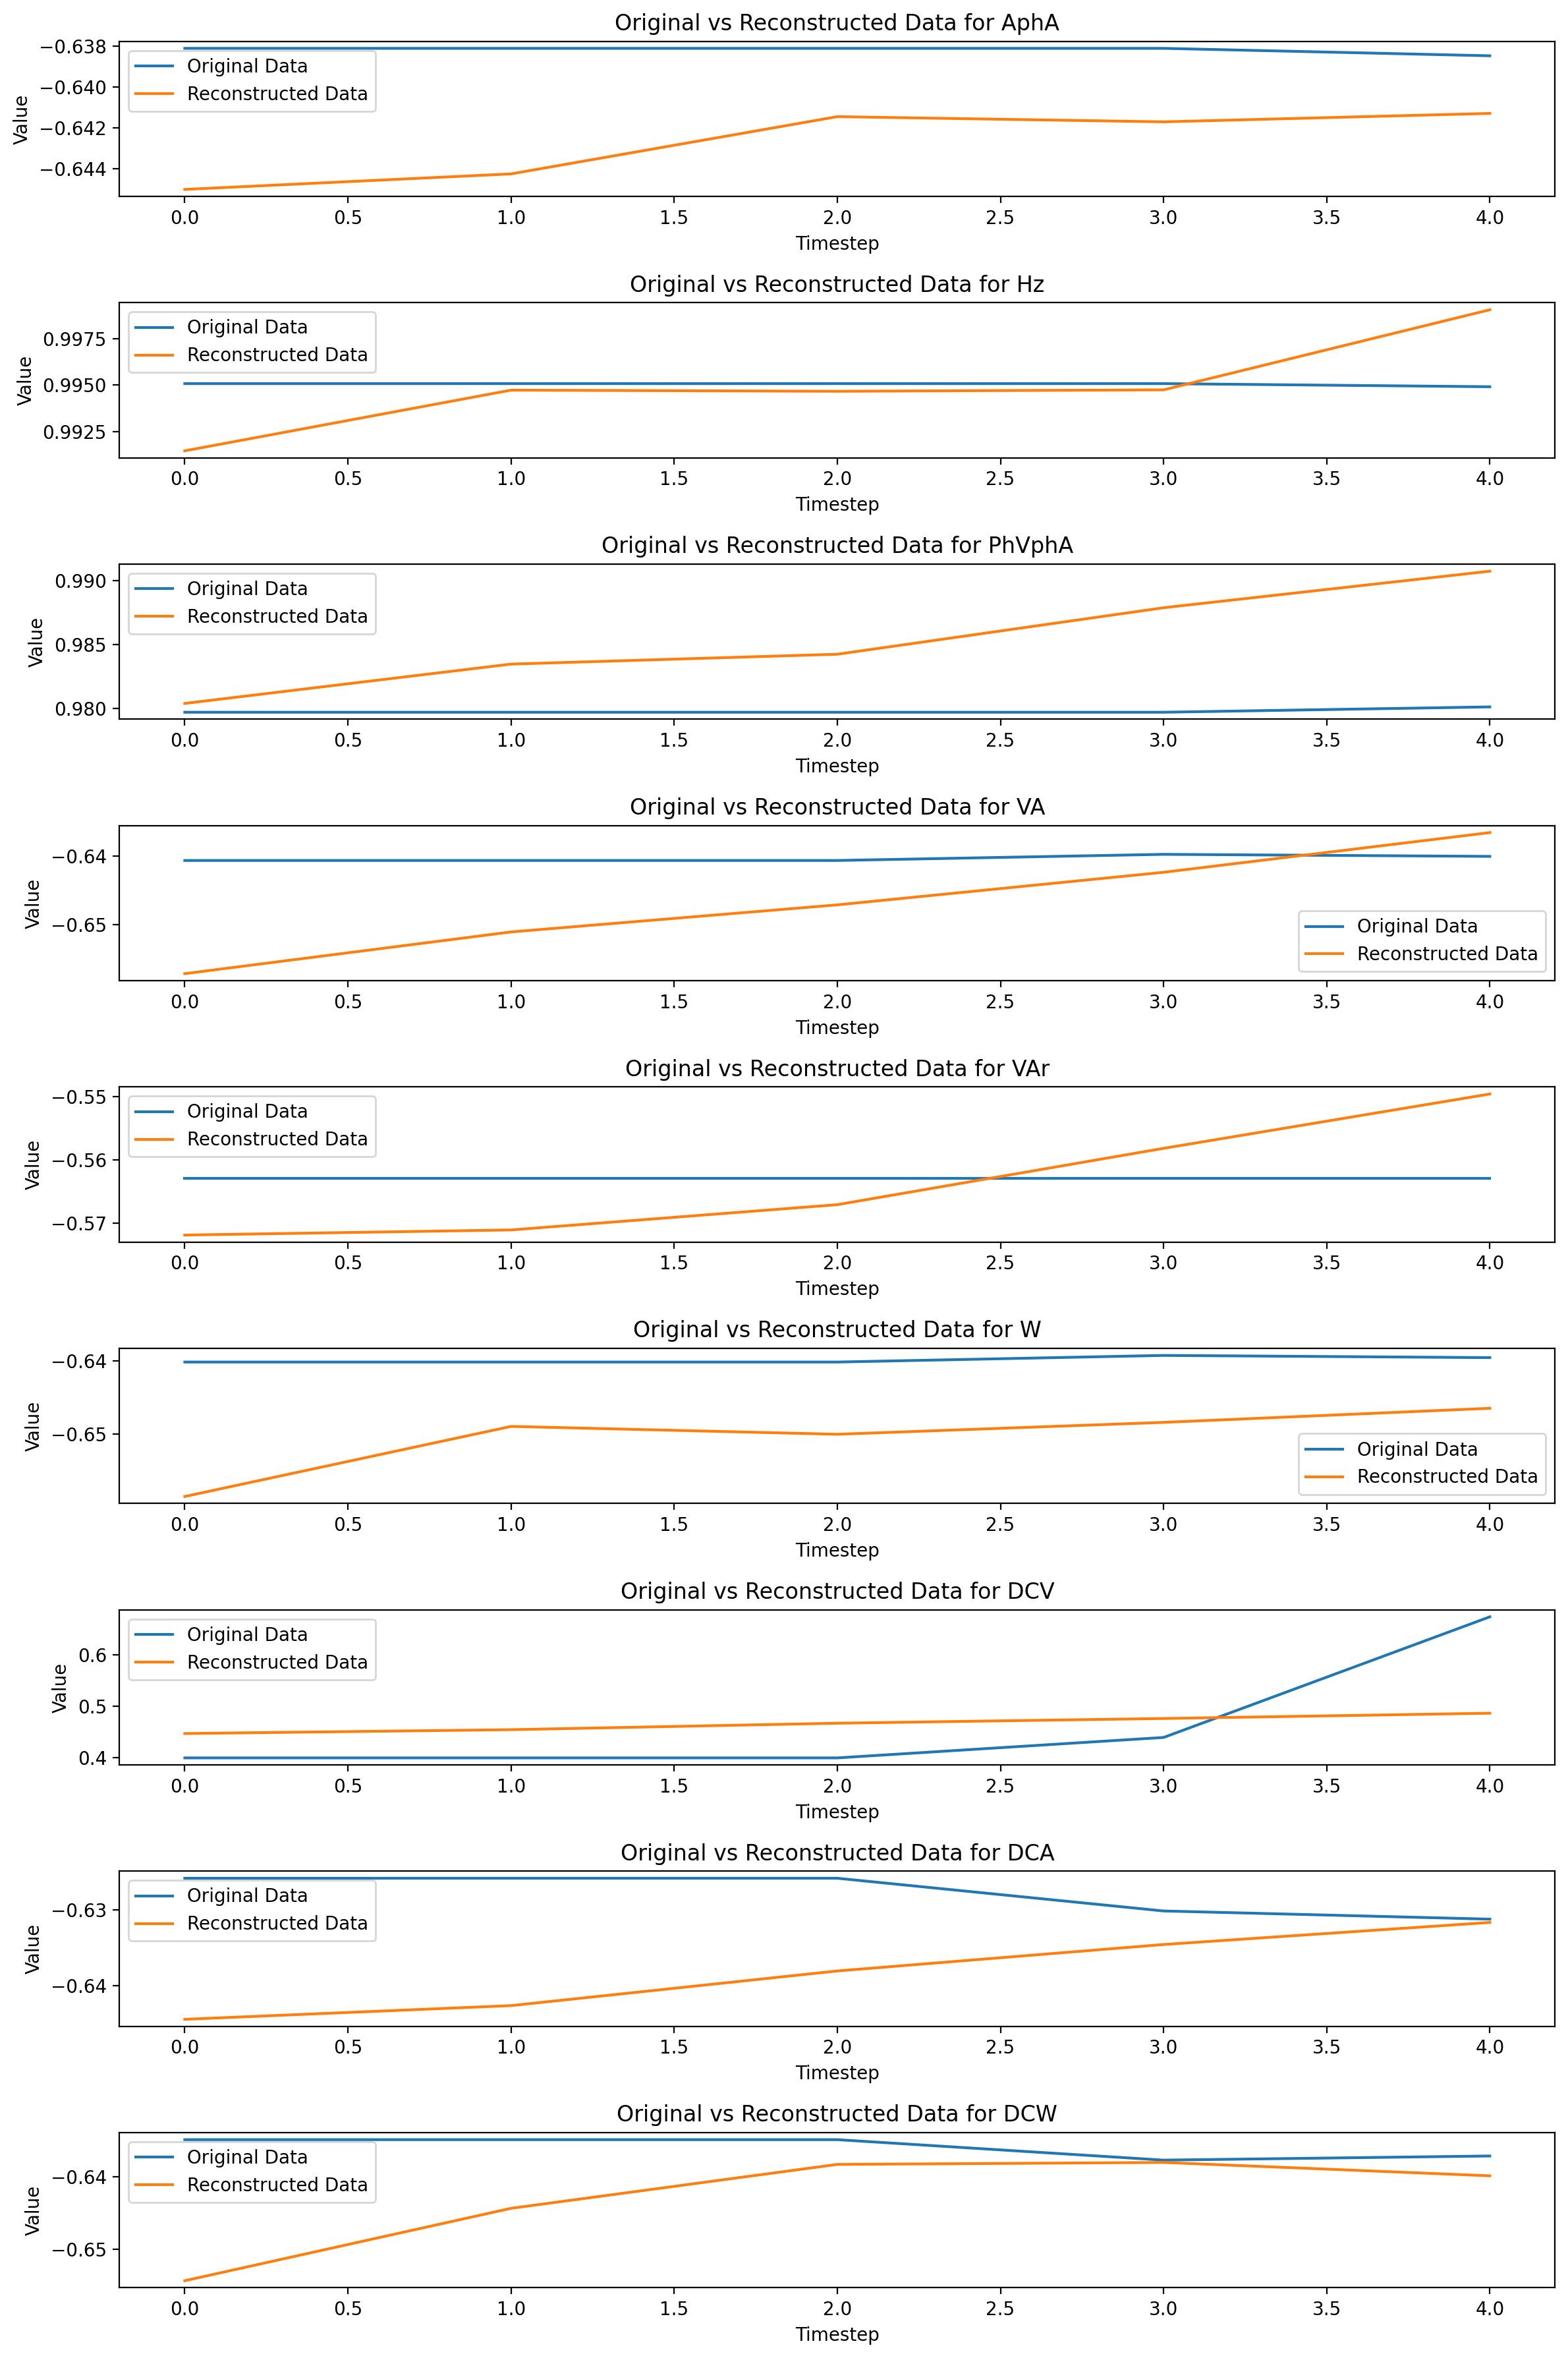

In [45]:

# Function to plot original vs reconstructed data
def plot_original_vs_reconstructed(original_data, reconstructed_data, feature_names):
    num_features = original_data.shape[2]  # Number of features in the data
    fig, axs = plt.subplots(num_features, figsize=(12, 2 * num_features))
    axs = axs if num_features > 1 else [axs]  # Ensure axs is always iterable

    for i in range(num_features):
        # Plot the first sequence's features
        axs[i].plot(original_data[0, :, i], label='Original Data')
        axs[i].plot(reconstructed_data[0, :, i], label='Reconstructed Data')
        axs[i].set_title(f'Original vs Reconstructed Data for {feature_names[i]}')
        axs[i].set_xlabel('Timestep')
        axs[i].set_ylabel('Value')
        axs[i].legend()

    plt.tight_layout()
    plt.show()


feature_names = ['AphA', 'Hz', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']
plot_original_vs_reconstructed(X, reconstructions, feature_names)


In [46]:
#prediction
X_train_pred = autoencoder.predict(x_train)

15120/15120 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step


In [47]:

X_train_pred.shape

(483835, 5, 9)

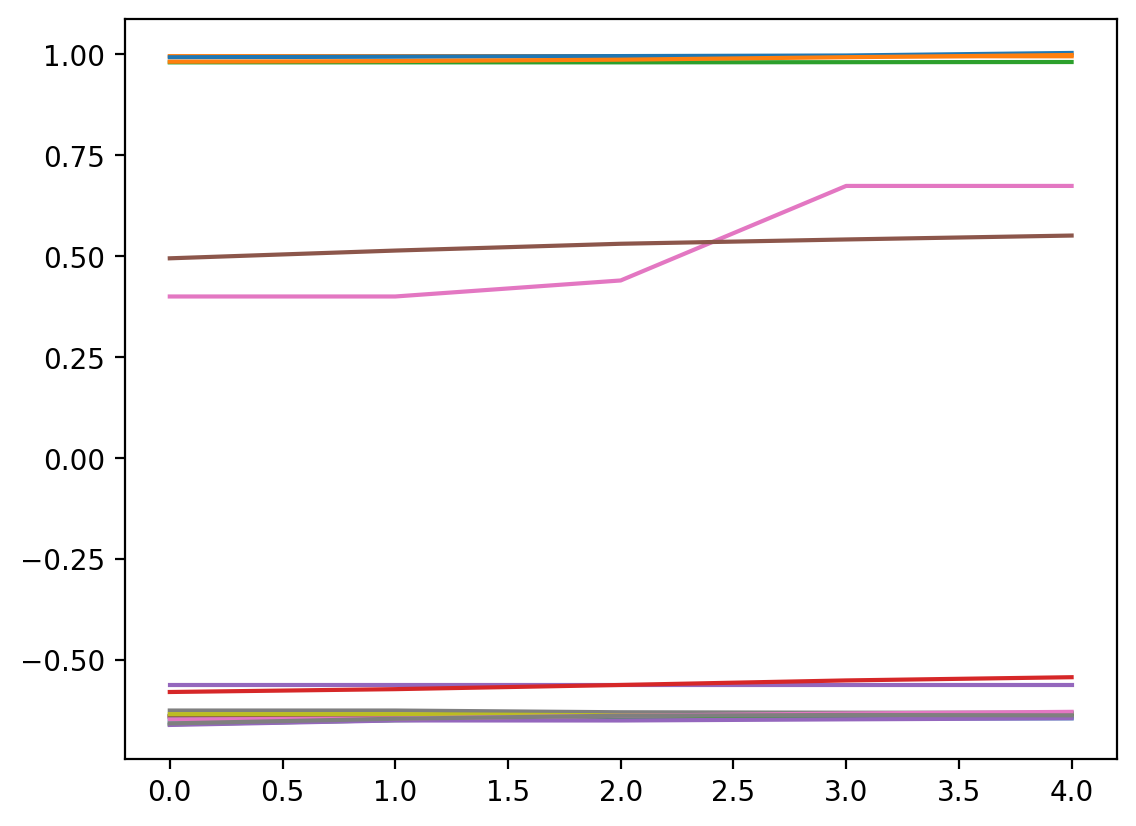

In [48]:
plt.plot(x_train[1])
plt.plot(X_train_pred[1])
plt.show()

In [49]:

def reconstruct_time_series(sequences):
    """
    Reconstruct the time series from sequences.
    
    sequences: numpy array of shape (num_sequences, sequence_length, num_features)
    
    Returns:
    Reconstructed time series as numpy array of shape (original_length, num_features)
    """
    num_sequences, sequence_length, num_features = sequences.shape
    original_length = num_sequences + sequence_length - 1  # Estimate original length
    time_series = np.zeros((original_length, num_features))
    count_matrix = np.zeros((original_length, num_features))

    for i in range(num_sequences):
        time_series[i:i + sequence_length] += sequences[i]
        count_matrix[i:i + sequence_length] += 1

    time_series /= np.maximum(count_matrix, 1)  # Avoid division by zero

    return time_series


def plot_reconstructed_time_series1(original_time_series, reconstructed_time_series, feature_index, feature_names):
    """
    Plot the original and reconstructed time series for a specific feature.
    
    original_time_series: numpy array of shape (original_length, num_features)
    reconstructed_time_series: numpy array of shape (original_length, num_features)
    feature_index: Index of the feature to plot
    feature_names: List of feature names corresponding to the features in the time series
    """

    feature_name = feature_names[feature_index]

    plt.figure(figsize=(10, 6))
    plt.plot(original_time_series[:, feature_index], label="Original Data")
    plt.plot(reconstructed_time_series[:, feature_index], label="Reconstructed Data")
    plt.title(f'Time Series Reconstruction for Feature: {feature_name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



# Reconstruct the time series
original_time_series = reconstruct_time_series(X)
reconstructed_time_series = reconstruct_time_series(reconstructions)



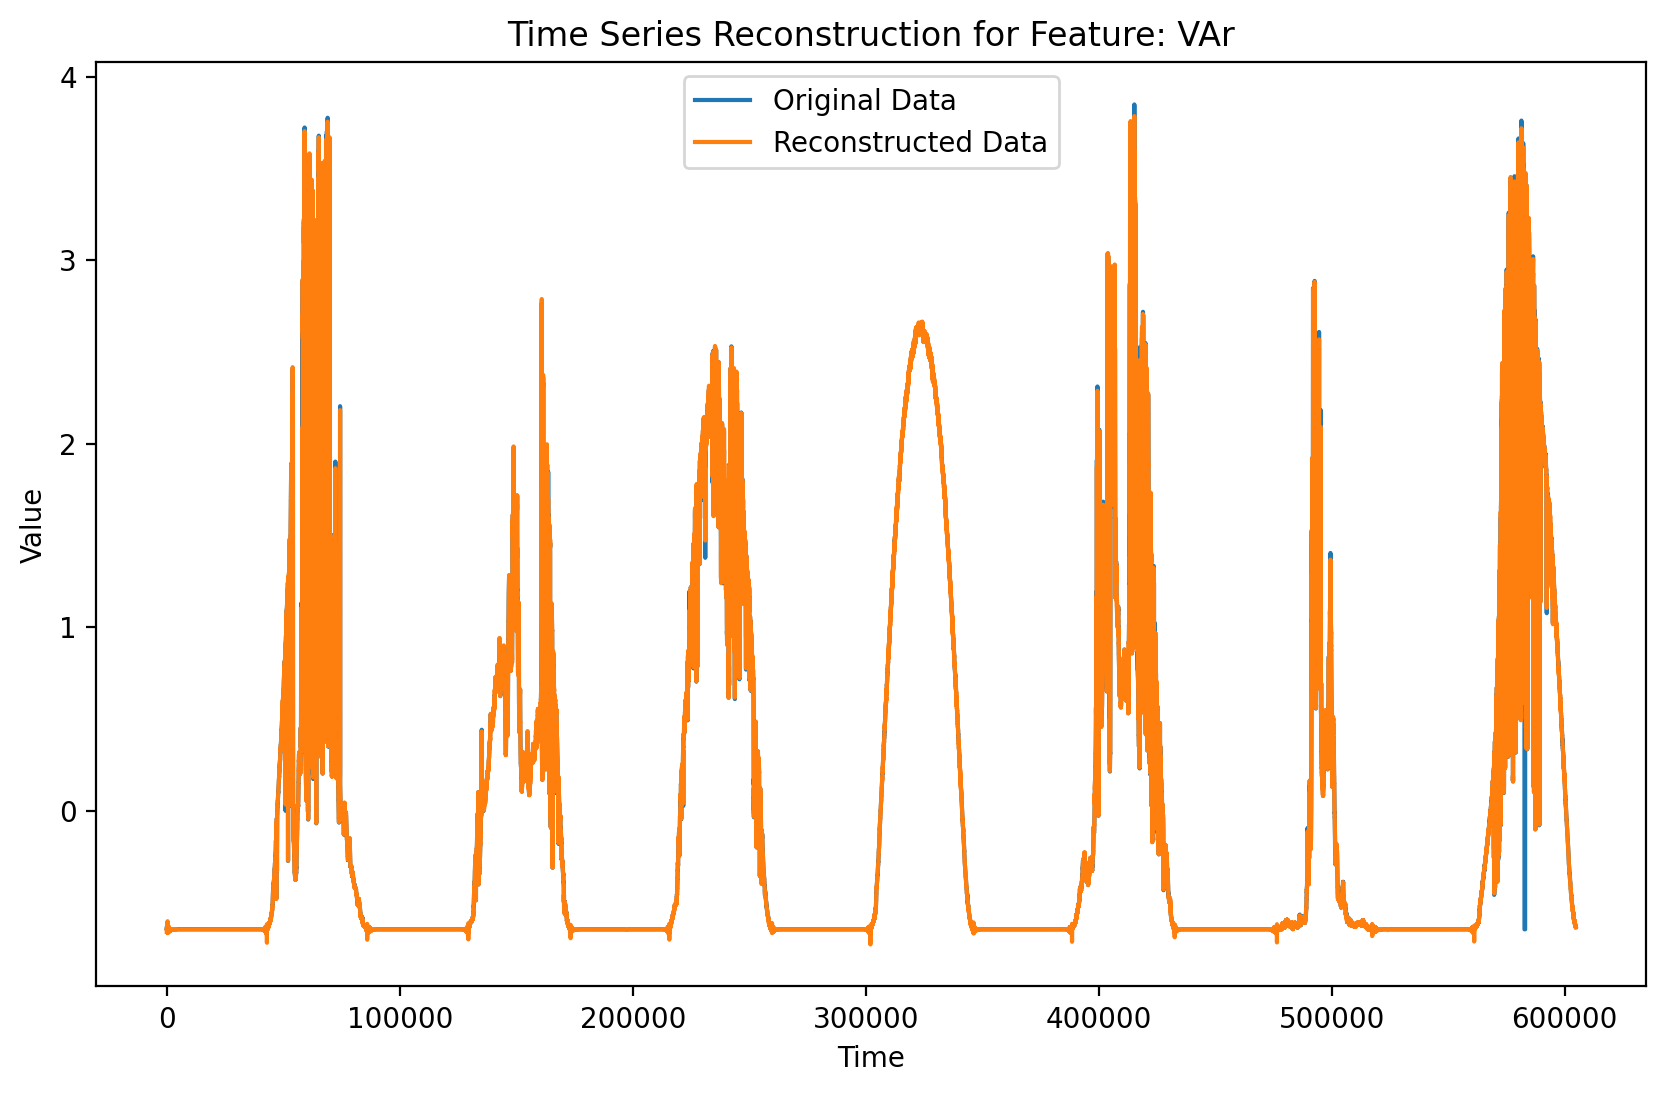

In [50]:
feature_names = ['AphA', 'Hz', 'PF', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']
plot_reconstructed_time_series1(original_time_series, reconstructed_time_series, feature_index=5, feature_names=feature_names)



In [51]:

def plot_reconstructed_time_series(original_time_series, reconstructed_time_series, feature_index, start_idx, end_idx, feature_names):
    
    feature_name = feature_names[feature_index]
    # Plot a portion of the original and reconstructed time series
    plt.figure(figsize=(10, 6))
    
    # Plot only a portion of the data based on start_idx and end_idx
    plt.title(f'Time Series Reconstruction for Feature: {feature_name}')
    plt.plot(original_time_series[start_idx:end_idx, feature_index], label="Original Data")
    plt.plot(reconstructed_time_series[start_idx:end_idx, feature_index], label="Reconstructed Data")
    
    plt.xlabel("Time Steps")
    plt.ylabel("Feature Value")
    plt.title(f"Original vs Reconstructed Data for Feature {feature_name}")
    plt.legend()
    plt.show()




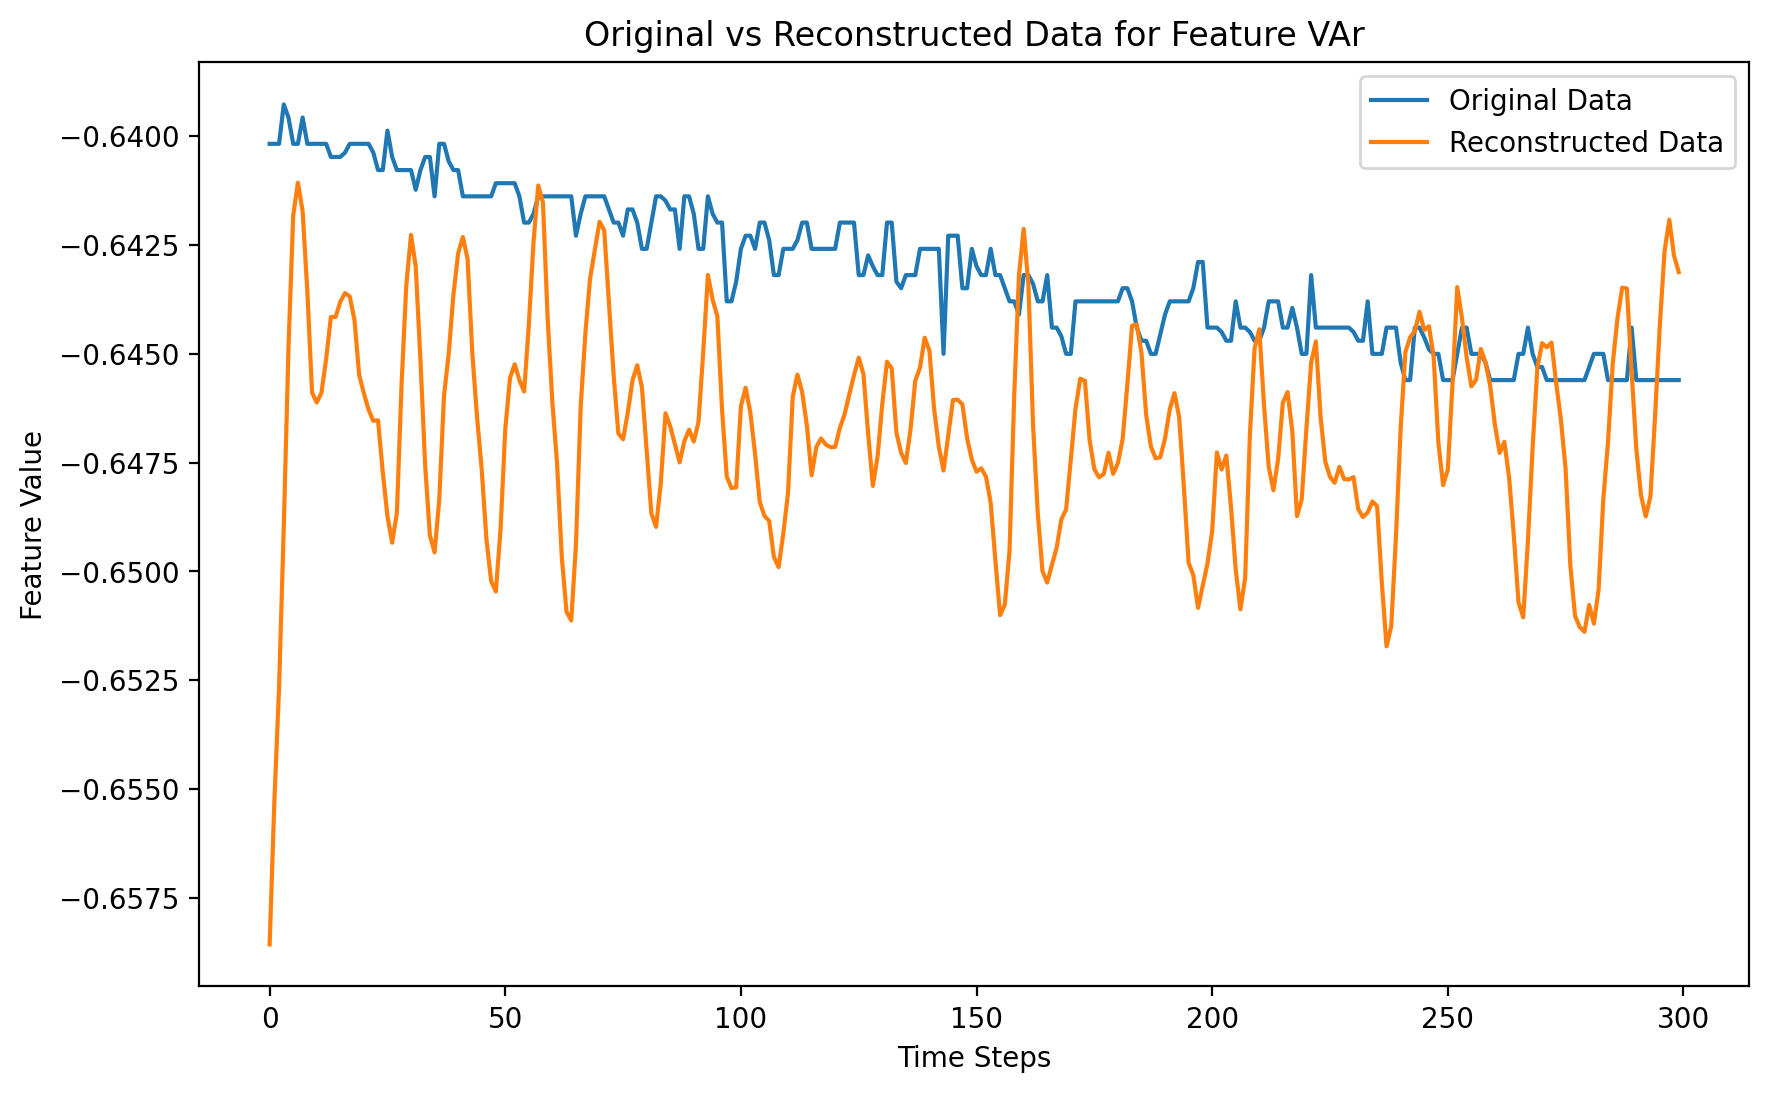

In [52]:
# Define your feature index and the portion of the data you want to plot
feature_index = 5 # Index of the feature you want to plot
start_idx = 0  # Starting index of the portion you want to plot
end_idx = 300 # Ending index of the portion you want to plot
feature_names = ['AphA', 'Hz', 'PF', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']
# Plot the selected portion of the original and reconstructed time series
plot_reconstructed_time_series(original_time_series, reconstructed_time_series, feature_index, start_idx, end_idx, feature_names=feature_names)


In [53]:
solar_data['Hz'].value_counts()

Hz
0.000     300942
60.010     54792
60.000     51491
59.990     50941
59.980     50376
59.970     32390
60.020     31114
59.960     14338
60.030      7365
59.950      4023
60.007       556
59.987       533
59.997       517
60.003       433
59.993       413
60.017       385
59.977       380
59.983       375
59.973       295
60.013       278
59.940       271
59.985       224
60.005       209
59.995       206
59.975       181
59.967       168
60.023       164
60.015       155
60.027       138
59.963       133
60.040       128
59.992       124
60.002       111
59.982       104
60.012        84
60.025        77
59.972        75
59.957        75
59.965        69
59.953        59
59.962        36
59.955        31
59.952        17
59.947         6
59.945         4
60.037         4
60.033         3
30.000         1
29.985         1
59.943         1
40.013         1
60.035         1
59.942         1
Name: count, dtype: int64

## CORRUPTING MY DATASET

In [54]:

def corrupt_time_series_custom_random(data, corruption_funcs, corruption_ratio=0.1):
    """
    Corrupt the time series data at random timesteps using custom corruption functions for each feature.
    
    data: pandas DataFrame or numpy array of shape (num_timesteps, num_features)
    corruption_funcs: list of functions, each function corresponds to a feature
    corruption_ratio: float, ratio of timesteps to corrupt (e.g., 0.1 for 10% of the timesteps)
    
    Returns: 
        corrupted_data: pandas DataFrame or numpy array of the same shape as data
        true_anomalies: numpy array of shape (num_timesteps,), with 1 indicating an anomaly and 0 otherwise
    """
    num_timesteps = data.shape[0]
    num_corruptions = int(num_timesteps * corruption_ratio)
    
    # Randomly select timesteps to corrupt
    random_timesteps = np.random.choice(num_timesteps, size=num_corruptions, replace=False)
    
    # Initialize true_anomalies array
    true_anomalies = np.zeros(num_timesteps)
    true_anomalies[random_timesteps] = 1
    
    corrupted_data = data.copy()
    
    # Iterate over each feature
    for feature_idx in range(data.shape[1]):
        # Get the specific corruption function for this feature
        corruption_func = corruption_funcs[feature_idx]
        
        # Corrupt the selected random timesteps for this feature
        for timestep in random_timesteps:
            corrupted_data.iloc[timestep, feature_idx] = corruption_func(data.iloc[timestep, feature_idx])
    
    return corrupted_data, true_anomalies


# custom corruption functions for each feature

def corrupt_AphA(value):
    """Corrupt function for AphA (current/phase current)"""
    # Randomly choose to corrupt the value
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        # Randomly assign a value less than 0
        return np.random.uniform(-100, 0)  # Random value between -100 and 0
    else:
        # Randomly assign a value greater than or equal to 100
        return np.random.uniform(100, 200)  # Random value between 100 and 200

def corrupt_HZ(value):
    """Corrupt function for Frequency (Hz)"""
    # Define the range for normal frequencies
    normal_min = 45
    normal_max = 61

    # Randomly choose to corrupt the value
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        # Randomly assign a value less than the minimum normal range
        return np.random.uniform(-100, normal_min)  # Random value between -100 and normal_min
    else:
        # Randomly assign a value greater than the maximum normal range
        return np.random.uniform(normal_max, 200)  # Random value between normal_max and 200

def corrupt_PhVphA(value):
    """Corrupt function for Phase Voltage (PhVphA)"""
    
    # Define the bounds
    lower_bound = 0
    upper_bound = 270
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        # Randomly choose to set the value less than lower_bound or greater than upper_bound
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-50, 0)  # Random value between -50 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(270, 320)  # Random value between 270 and 320
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)

def corrupt_VA(value):
    """Corrupt function for Apparent Power (VA)"""
    
    # Define the bounds for normal values
    lower_bound = 0
    upper_bound = 15000
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-10000, 0)  # Random value between -10000 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(15000, 30000)  # Random value between 15000 and 30000
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)
    
def corrupt_VAr(value):
    """Corrupt function for Reactive Power (VAr)"""
    
    # Define the bounds for normal values
    lower_bound = 0
    upper_bound = 50
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-50, 0)  # Random value between -50 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(50, 200)  # Random value between 50 and 200
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)


def corrupt_W(value):
    """Corrupt function for Real Power (W)"""
    
    # Define the bounds for normal values
    lower_bound = 0
    upper_bound = 15000
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-10000, 0)  # Random value between -10000 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(15000, 30000)  # Random value between 15000 and 30000
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)

def corrupt_DCV(value):
    """Corrupt function for DC Voltage (DCV)"""
     # Define the bounds for normal values
    lower_bound = 0
    upper_bound = 600
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-50, 0)  # Random value between -50 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(600, 2000)  # Random value between 600 and 2000
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)

def corrupt_DCA(value):
    """Corrupt function for DC Current (DCA)"""
    # Define the bounds for normal values
    lower_bound = 0
    upper_bound = 50
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-50, 0)  # Random value between -50 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(50, 150)  # Random value between 50 and 150
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)

def corrupt_DCW(value):
    """Corrupt function for DC Power (DCW)"""
     # Define the bounds for normal values
    lower_bound = 0
    upper_bound = -16000
    
    # Decide whether to introduce an anomaly
    if np.random.rand() < 0.5:  # 50% chance to corrupt
        if np.random.rand() < 0.5:
            # Set to a random value less than lower_bound
            return np.random.uniform(-10000, 0)  # Random value between -50 and 0
        else:
            # Set to a random value greater than upper_bound
            return np.random.uniform(16000, 30000)  # Random value between 50 and 150
    else:
        # Return the value but ensure it is within the bounds
        return np.clip(value, lower_bound, upper_bound)


# List of corruption functions, one for each feature in the order of the features
corruption_funcs = [corrupt_AphA, corrupt_HZ, corrupt_PhVphA, corrupt_VA, corrupt_VAr, corrupt_W, corrupt_DCV, corrupt_DCA, corrupt_DCW]


# Corrupt the data using the custom corruption functions every 10th timestep
corrupted_data, true_anomalies = corrupt_time_series_custom_random(solar_data, corruption_funcs, corruption_ratio=0.1)


In [55]:

corrupted_data["Target"] = true_anomalies

In [56]:

print(f'original data:{solar_data} /n corrupted data: {corrupted_data}')


original data:                      AphA      Hz  PhVphA    VA  VAr     W     DCV   DCA  \
timestamp                                                                   
2024-03-17 00:00:00  0.160  59.990  236.90  18.0  0.0  18.0  262.35  0.16   
2024-03-17 00:00:01  0.160  59.990  236.90  18.0  0.0  18.0  262.35  0.16   
2024-03-17 00:00:02  0.160  59.990  236.90  18.0  0.0  18.0  262.35  0.16   
2024-03-17 00:00:03  0.160  59.990  236.90  21.0  0.0  21.0  269.50  0.12   
2024-03-17 00:00:04  0.155  59.985  236.95  20.0  0.0  20.0  311.70  0.11   
...                    ...     ...     ...   ...  ...   ...     ...   ...   
2024-03-23 23:59:54  0.250  60.000  237.20  46.0  0.0  46.0  333.65  0.24   
2024-03-23 23:59:55  0.255  60.000  237.20  47.0  0.0  47.0  311.15  0.27   
2024-03-23 23:59:56  0.260  60.000  237.20  48.0  0.0  48.0  311.15  0.27   
2024-03-23 23:59:57  0.260  60.000  237.20  48.0  0.0  48.0  311.15  0.27   
2024-03-23 23:59:58  0.260  60.000  237.20  48.0  0.0  48.0  3

In [57]:

corrupted_data.describe()

,AphA,Hz,PhVphA,VA,VAr,W,DCV,DCA,DCW,Target
count,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000
mean,13.011510,32.258249,120.679324,2474.443836,7.236027,2470.581556,212.903397,7.519850,1643.294495,0.099999
std,37.440742,40.526154,121.805924,4765.105862,22.490237,4758.665833,258.116645,18.719348,6281.316204,0.299998
min,-99.999856,-99.997078,-49.996073,-9999.644202,-49.999783,-9999.824068,-49.997776,-49.999123,-16000.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.800000,0.000000,0.000000,0.000000
50%,0.160000,59.950000,232.900000,2.000000,0.000000,2.000000,307.150000,0.070000,0.000000,0.000000
75%,17.290000,60.000000,238.750000,3802.005000,7.000000,3793.500000,368.950000,10.360000,3643.680000,0.000000
max,199.997952,199.999097,319.994575,29999.535132,199.993228,29999.288671,1999.945474,149.999768,29999.609961,1.000000


In [58]:

solar_data.describe()

,AphA,Hz,PhVphA,VA,VAr,W,DCV,DCA,DCW
count,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000
mean,8.930898,30.141278,119.944340,2146.417949,4.962261,2139.735070,190.314730,5.977347,2206.083361
std,13.745224,29.996440,119.381241,3322.463418,8.815379,3314.311493,180.206522,9.294987,3408.940342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.800000,0.000000,0.000000
50%,0.160000,59.950000,232.900000,2.000000,0.000000,2.000000,306.750000,0.070000,19.667000
75%,14.833000,59.990000,238.600000,3548.005500,6.000000,3538.000000,367.950000,9.700000,3641.028000
max,61.310000,60.040000,270.000000,14894.062000,45.000000,14894.000000,428.700000,42.630000,15397.956000


In [59]:

X_corr = corrupted_data.drop(columns = ['Target'])

In [60]:

# Normalize the corrupted data
norm_corrupted_data = scaler.fit_transform(X_corr)

# Create sequences from the normalized corrupted data
X_corrupted = create_sequences(norm_corrupted_data, seq_length)
# Evaluate the model on the corrupted data
loss_corrupted = autoencoder.evaluate(X_corrupted, X_corrupted, verbose=1)
print(f"Loss on corrupted data: {loss_corrupted}")


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 0.6316
Loss on corrupted data: 0.6211617588996887


In [61]:

# evaluate the model on normal test data
loss_normal = autoencoder.evaluate(x_test, x_test, verbose=1)
print(f"Loss on normal test data: {loss_normal}")

3780/3780 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0016
Loss on normal test data: 0.007138517685234547


3780/3780 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


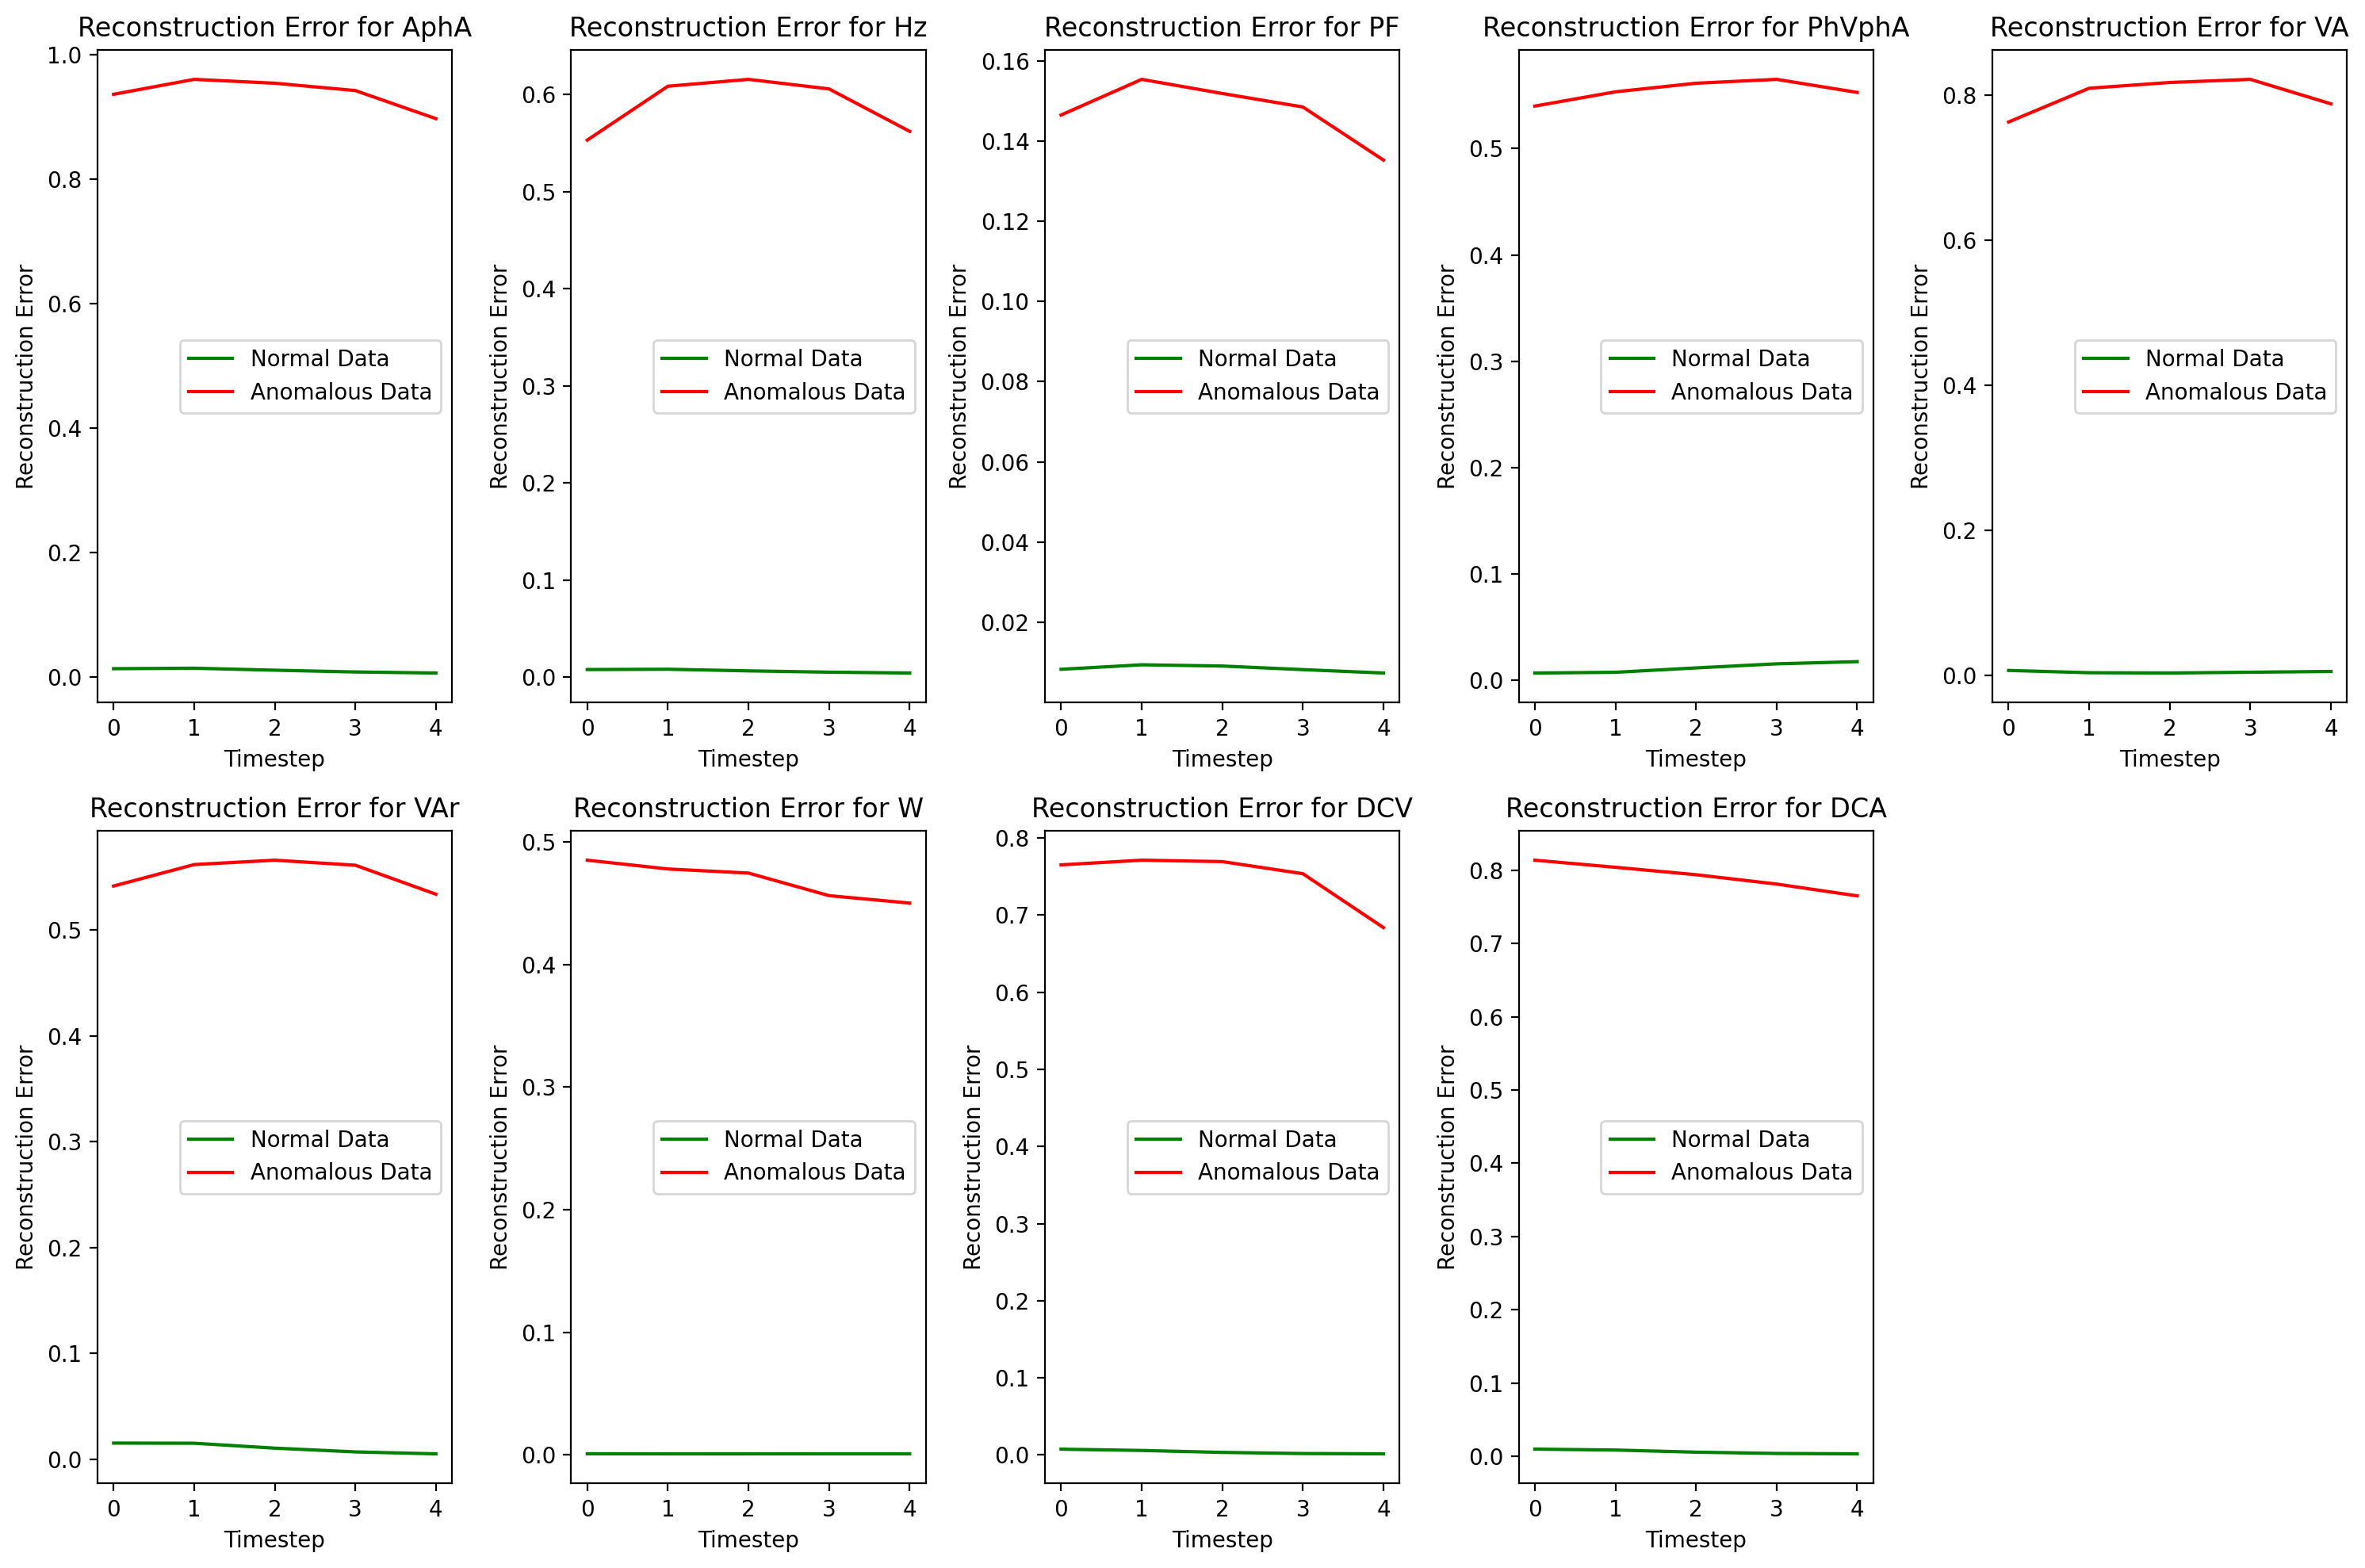

In [62]:
# Function to calculate reconstruction error for each feature
def calculate_reconstruction_error(original_data, reconstructed_data):
    return np.mean(np.square(original_data - reconstructed_data), axis=0)  # MSE for each feature

# Reconstruct the data using the autoencoder
reconstructed_normal_data = autoencoder.predict(x_test)
reconstructed_anomalous_data = autoencoder.predict(X_corrupted)

# Calculate the reconstruction error for normal and anomalous data
reconstruction_error_normal = calculate_reconstruction_error(x_test, reconstructed_normal_data)
reconstruction_error_anomalous = calculate_reconstruction_error(X_corrupted, reconstructed_anomalous_data)

# Plot the reconstruction error for each feature
num_features = x_test.shape[2]
feature_names = ['AphA', 'Hz', 'PF', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']  # Update with actual feature names

plt.figure(figsize=(15, 10))

for i in range(num_features):
    plt.subplot(2, (num_features + 1) // 2, i + 1)
    plt.plot(reconstruction_error_normal[:, i], label="Normal Data", color='green')
    plt.plot(reconstruction_error_anomalous[:, i], label="Anomalous Data", color='red')
    plt.title(f'Reconstruction Error for {feature_names[i]}')
    plt.xlabel('Timestep')
    plt.ylabel('Reconstruction Error')
    plt.legend()

plt.tight_layout()
plt.show()


In [63]:
# Verify the shapes of the reconstruction error arrays
print(f"Shape of reconstruction_error_normal: {reconstruction_error_normal.shape}")
print(f"Shape of reconstruction_error_anomalous: {reconstruction_error_anomalous.shape}")

# Verify the length of the feature names
print(f"Number of features in feature_names: {len(feature_names)}")

# Verify the length of the sensitivity array
sensitivity = np.mean(reconstruction_error_anomalous, axis=0) - np.mean(reconstruction_error_normal, axis=0)
print(f"Length of sensitivity array: {len(sensitivity)}")

# If the lengths match, proceed with creating the DataFrame
if len(feature_names) == len(sensitivity):
    sensitivity_df = pd.DataFrame({
        'Feature': feature_names,
        'Sensitivity': sensitivity
    })

    # Rank features by sensitivity in descending order
    sensitivity_df = sensitivity_df.sort_values(by='Sensitivity', ascending=False).reset_index(drop=True)
    print(sensitivity_df)
else:
    print("Mismatch between feature names and sensitivity array length. Please check your data.")


Shape of reconstruction_error_normal: (5, 9)
Shape of reconstruction_error_anomalous: (5, 9)
Number of features in feature_names: 10
Length of sensitivity array: 9
Mismatch between feature names and sensitivity array length. Please check your data.


In [64]:
# Example list of feature names
feature_names = ['AphA', 'Hz', 'PF', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']

# Remove the 'PF' column from the feature names
feature_names = [name for name in feature_names if name != 'PF']

print(feature_names)


['AphA', 'Hz', 'PhVphA', 'VA', 'VAr', 'W', 'DCV', 'DCA', 'DCW']


In [65]:
def calculate_sensitivity(reconstruction_error_normal, reconstruction_error_anomalous, feature_names):
    """
    Calculate and rank feature sensitivity based on reconstruction error differences between normal and corrupted data.
    
    reconstruction_error_normal: numpy array of shape (num_timesteps, num_features)
    reconstruction_error_anomalous: numpy array of shape (num_timesteps, num_features)
    feature_names: List of feature names corresponding to each feature in the data
    
    Returns: DataFrame with features ranked by sensitivity.
    """
    # Calculate the mean reconstruction error for each feature
    mean_error_normal = np.mean(reconstruction_error_normal, axis=0)
    mean_error_anomalous = np.mean(reconstruction_error_anomalous, axis=0)
    
    # Calculate the sensitivity as the difference in mean reconstruction error
    sensitivity = mean_error_anomalous - mean_error_normal
    
    # Create a DataFrame to store sensitivity values and feature names
    sensitivity_df = pd.DataFrame({
        'Feature': feature_names,
        'Sensitivity': sensitivity
    })
    
    # Rank features by sensitivity in descending order
    sensitivity_df = sensitivity_df.sort_values(by='Sensitivity', ascending=False).reset_index(drop=True)
    
    return sensitivity_df

# Example usage
sensitivity_df = calculate_sensitivity(reconstruction_error_normal, reconstruction_error_anomalous, feature_names)
print(sensitivity_df)


  Feature  Sensitivity
0    AphA     0.927209
1     VAr     0.795099
2     DCW     0.785014
3     DCA     0.744457
4      Hz     0.582908
5      VA     0.542701
6       W     0.542126
7     DCV     0.467739
8  PhVphA     0.138939


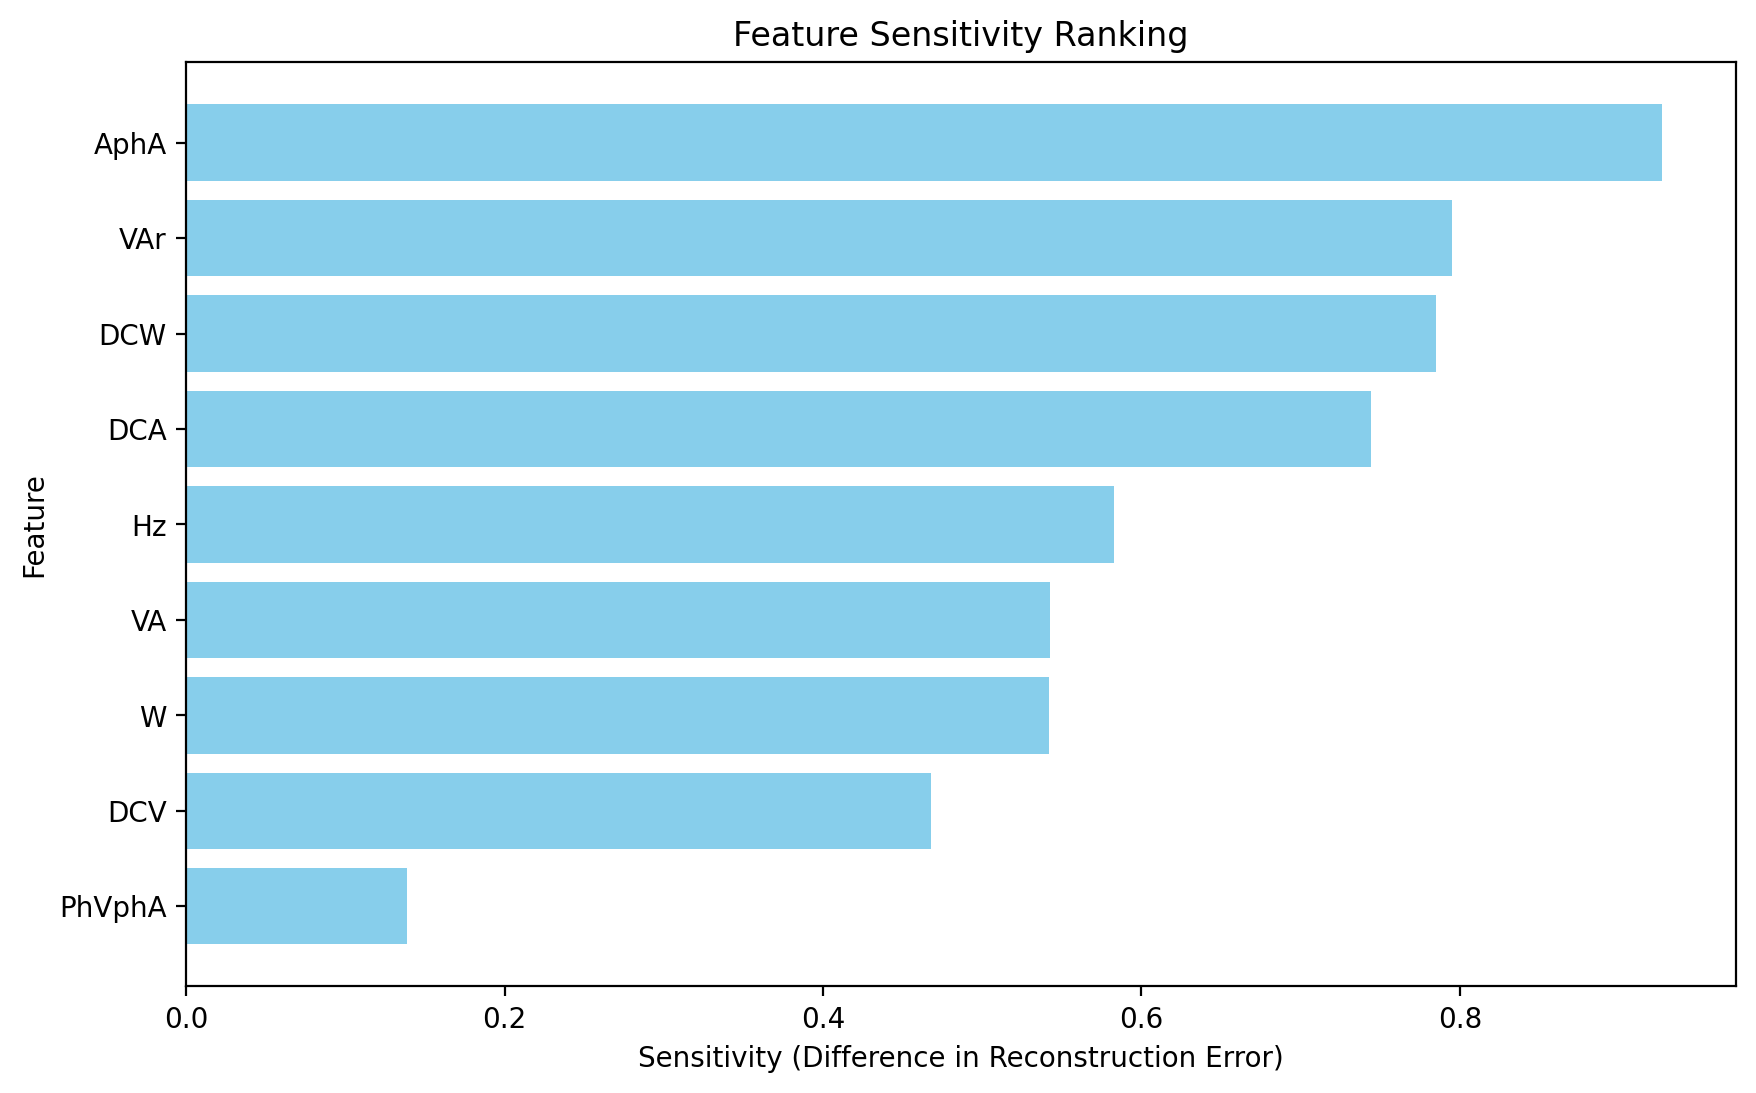

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(sensitivity_df['Feature'], sensitivity_df['Sensitivity'], color='skyblue')
plt.xlabel('Sensitivity (Difference in Reconstruction Error)')
plt.ylabel('Feature')
plt.title('Feature Sensitivity Ranking')
plt.gca().invert_yaxis()
plt.show()


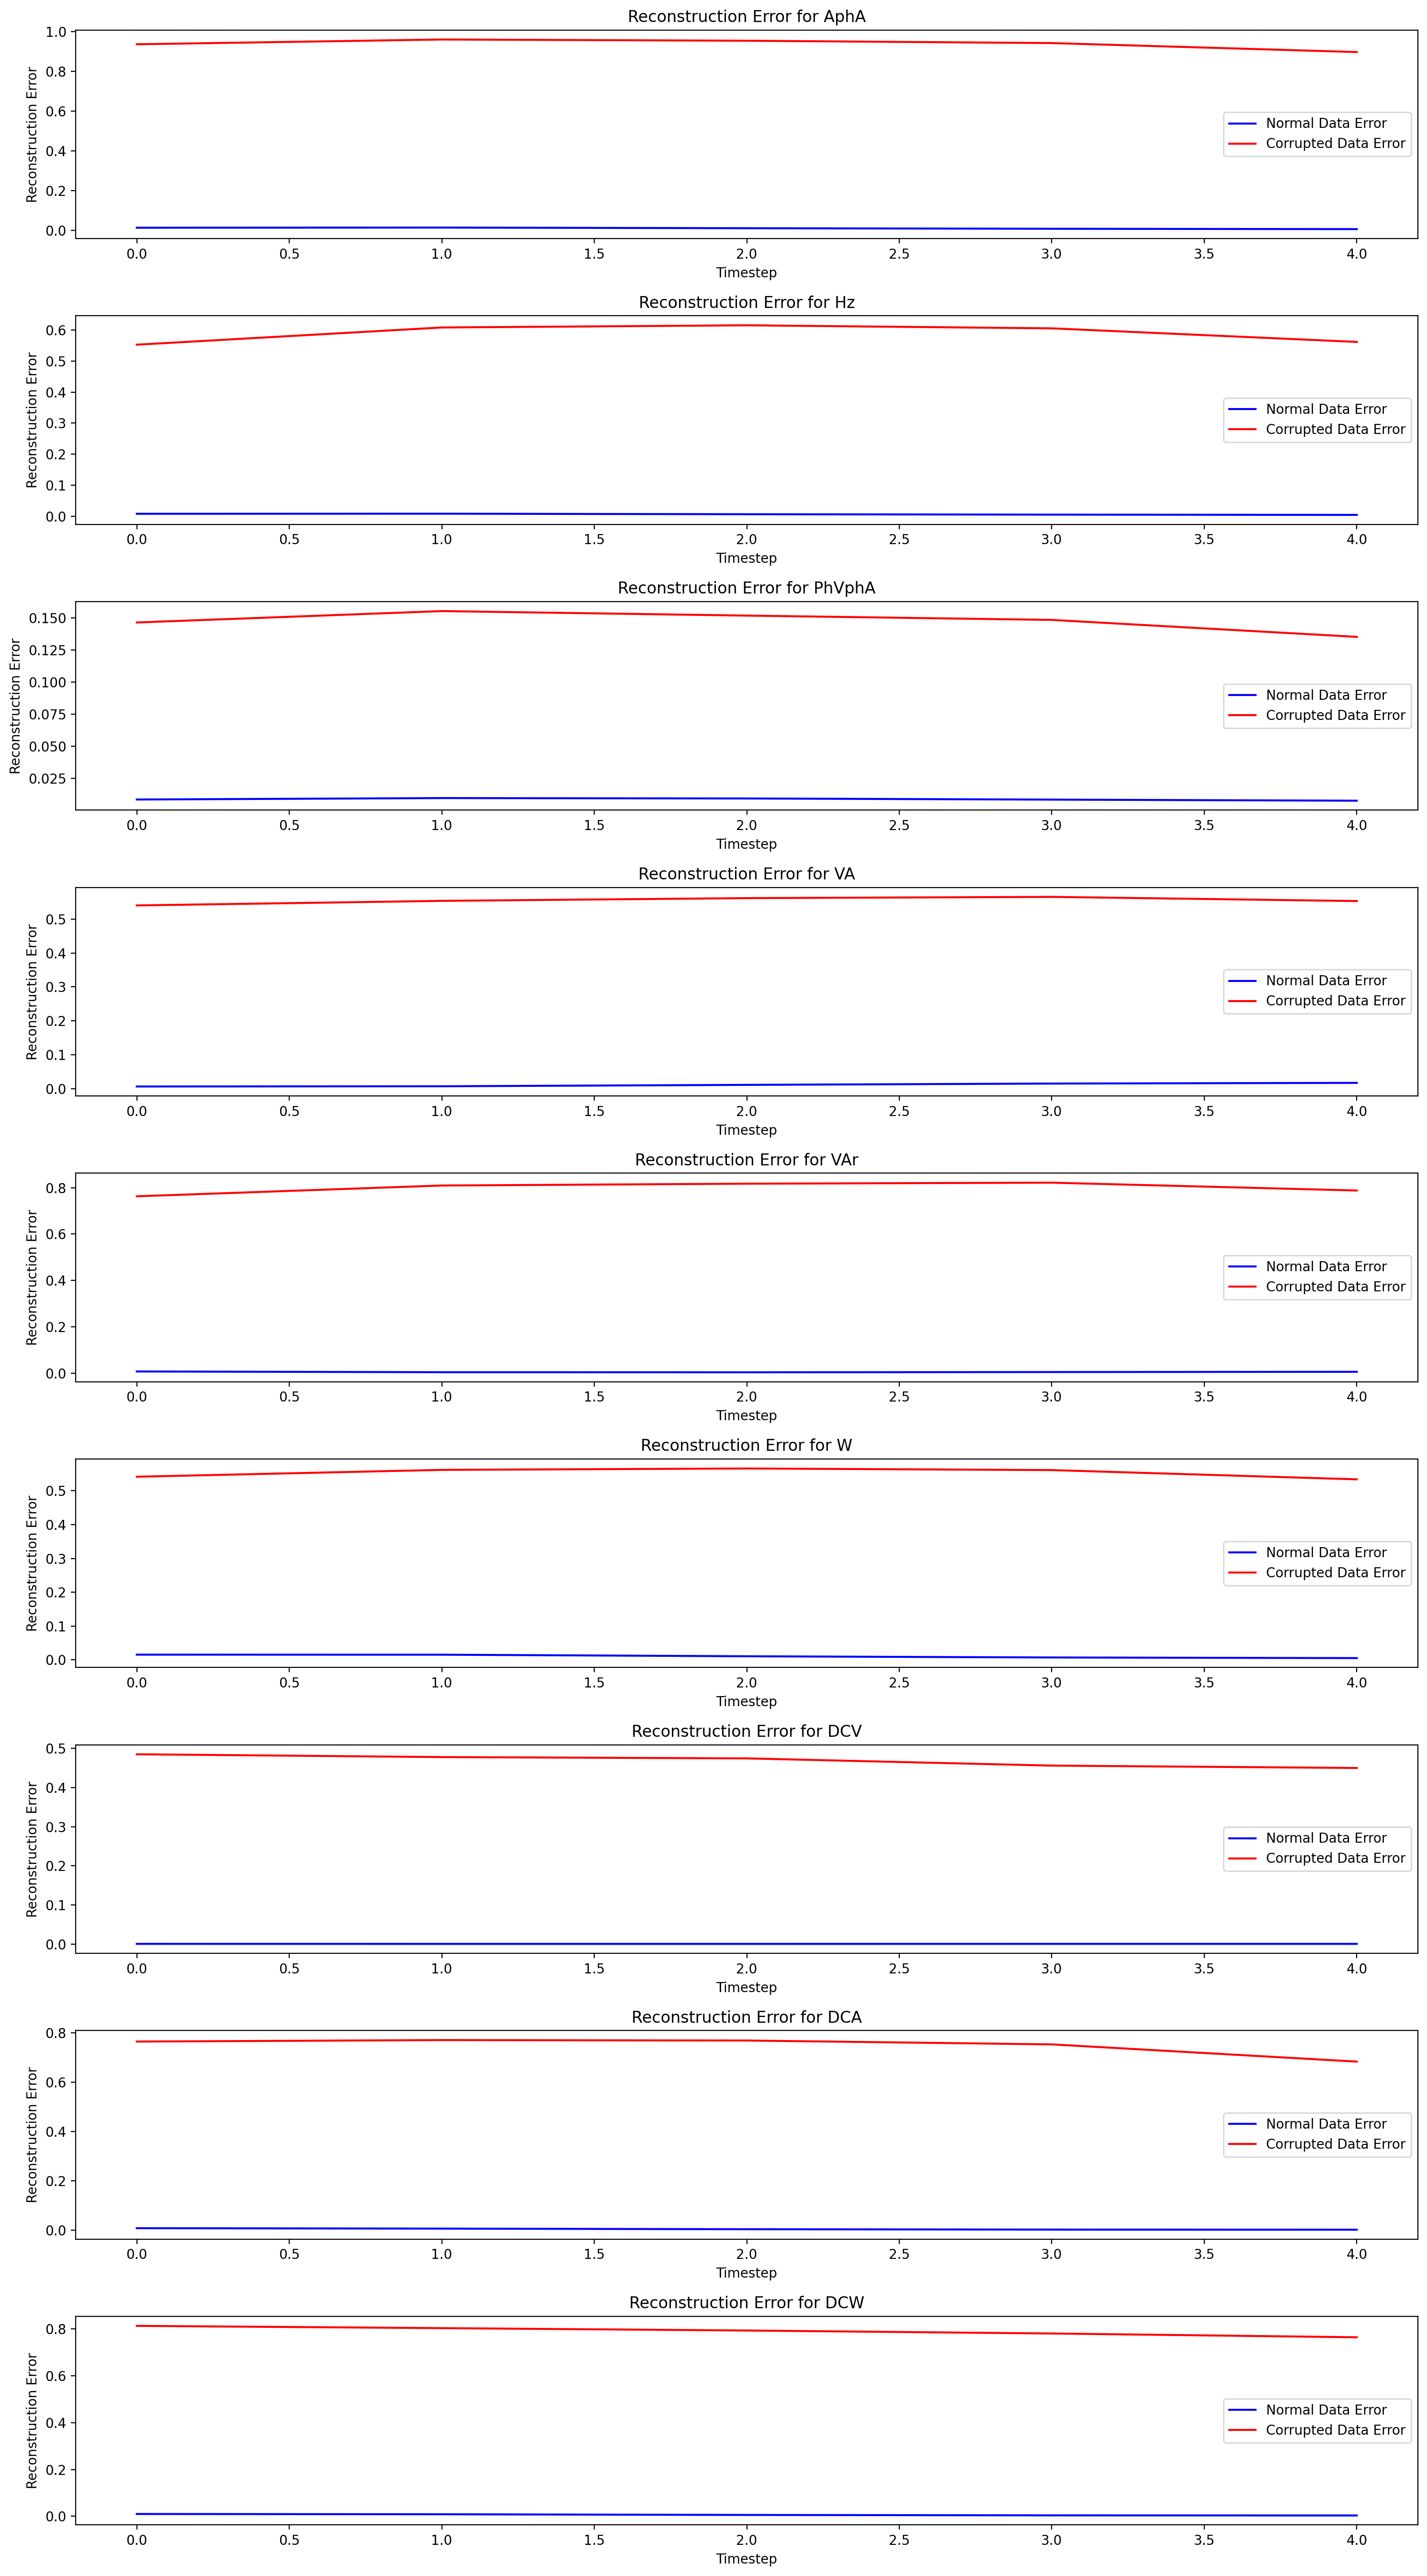

In [67]:
def plot_reconstruction_errors(reconstruction_error_normal, reconstruction_error_anomalous, feature_names):
    """
    Plot the time series of reconstruction errors for both normal and corrupted data.

    reconstruction_error_normal: numpy array of shape (num_timesteps, num_features)
    reconstruction_error_anomalous: numpy array of shape (num_timesteps, num_features)
    feature_names: List of feature names corresponding to each feature in the data
    """
    num_features = reconstruction_error_normal.shape[1]
    
    plt.figure(figsize=(15, num_features * 3))

    for i in range(num_features):
        plt.subplot(num_features, 1, i + 1)
        plt.plot(reconstruction_error_normal[:, i], label="Normal Data Error", color='blue')
        plt.plot(reconstruction_error_anomalous[:, i], label="Corrupted Data Error", color='red')
        plt.title(f'Reconstruction Error for {feature_names[i]}')
        plt.xlabel('Timestep')
        plt.ylabel('Reconstruction Error')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_reconstruction_errors(reconstruction_error_normal, reconstruction_error_anomalous, feature_names)


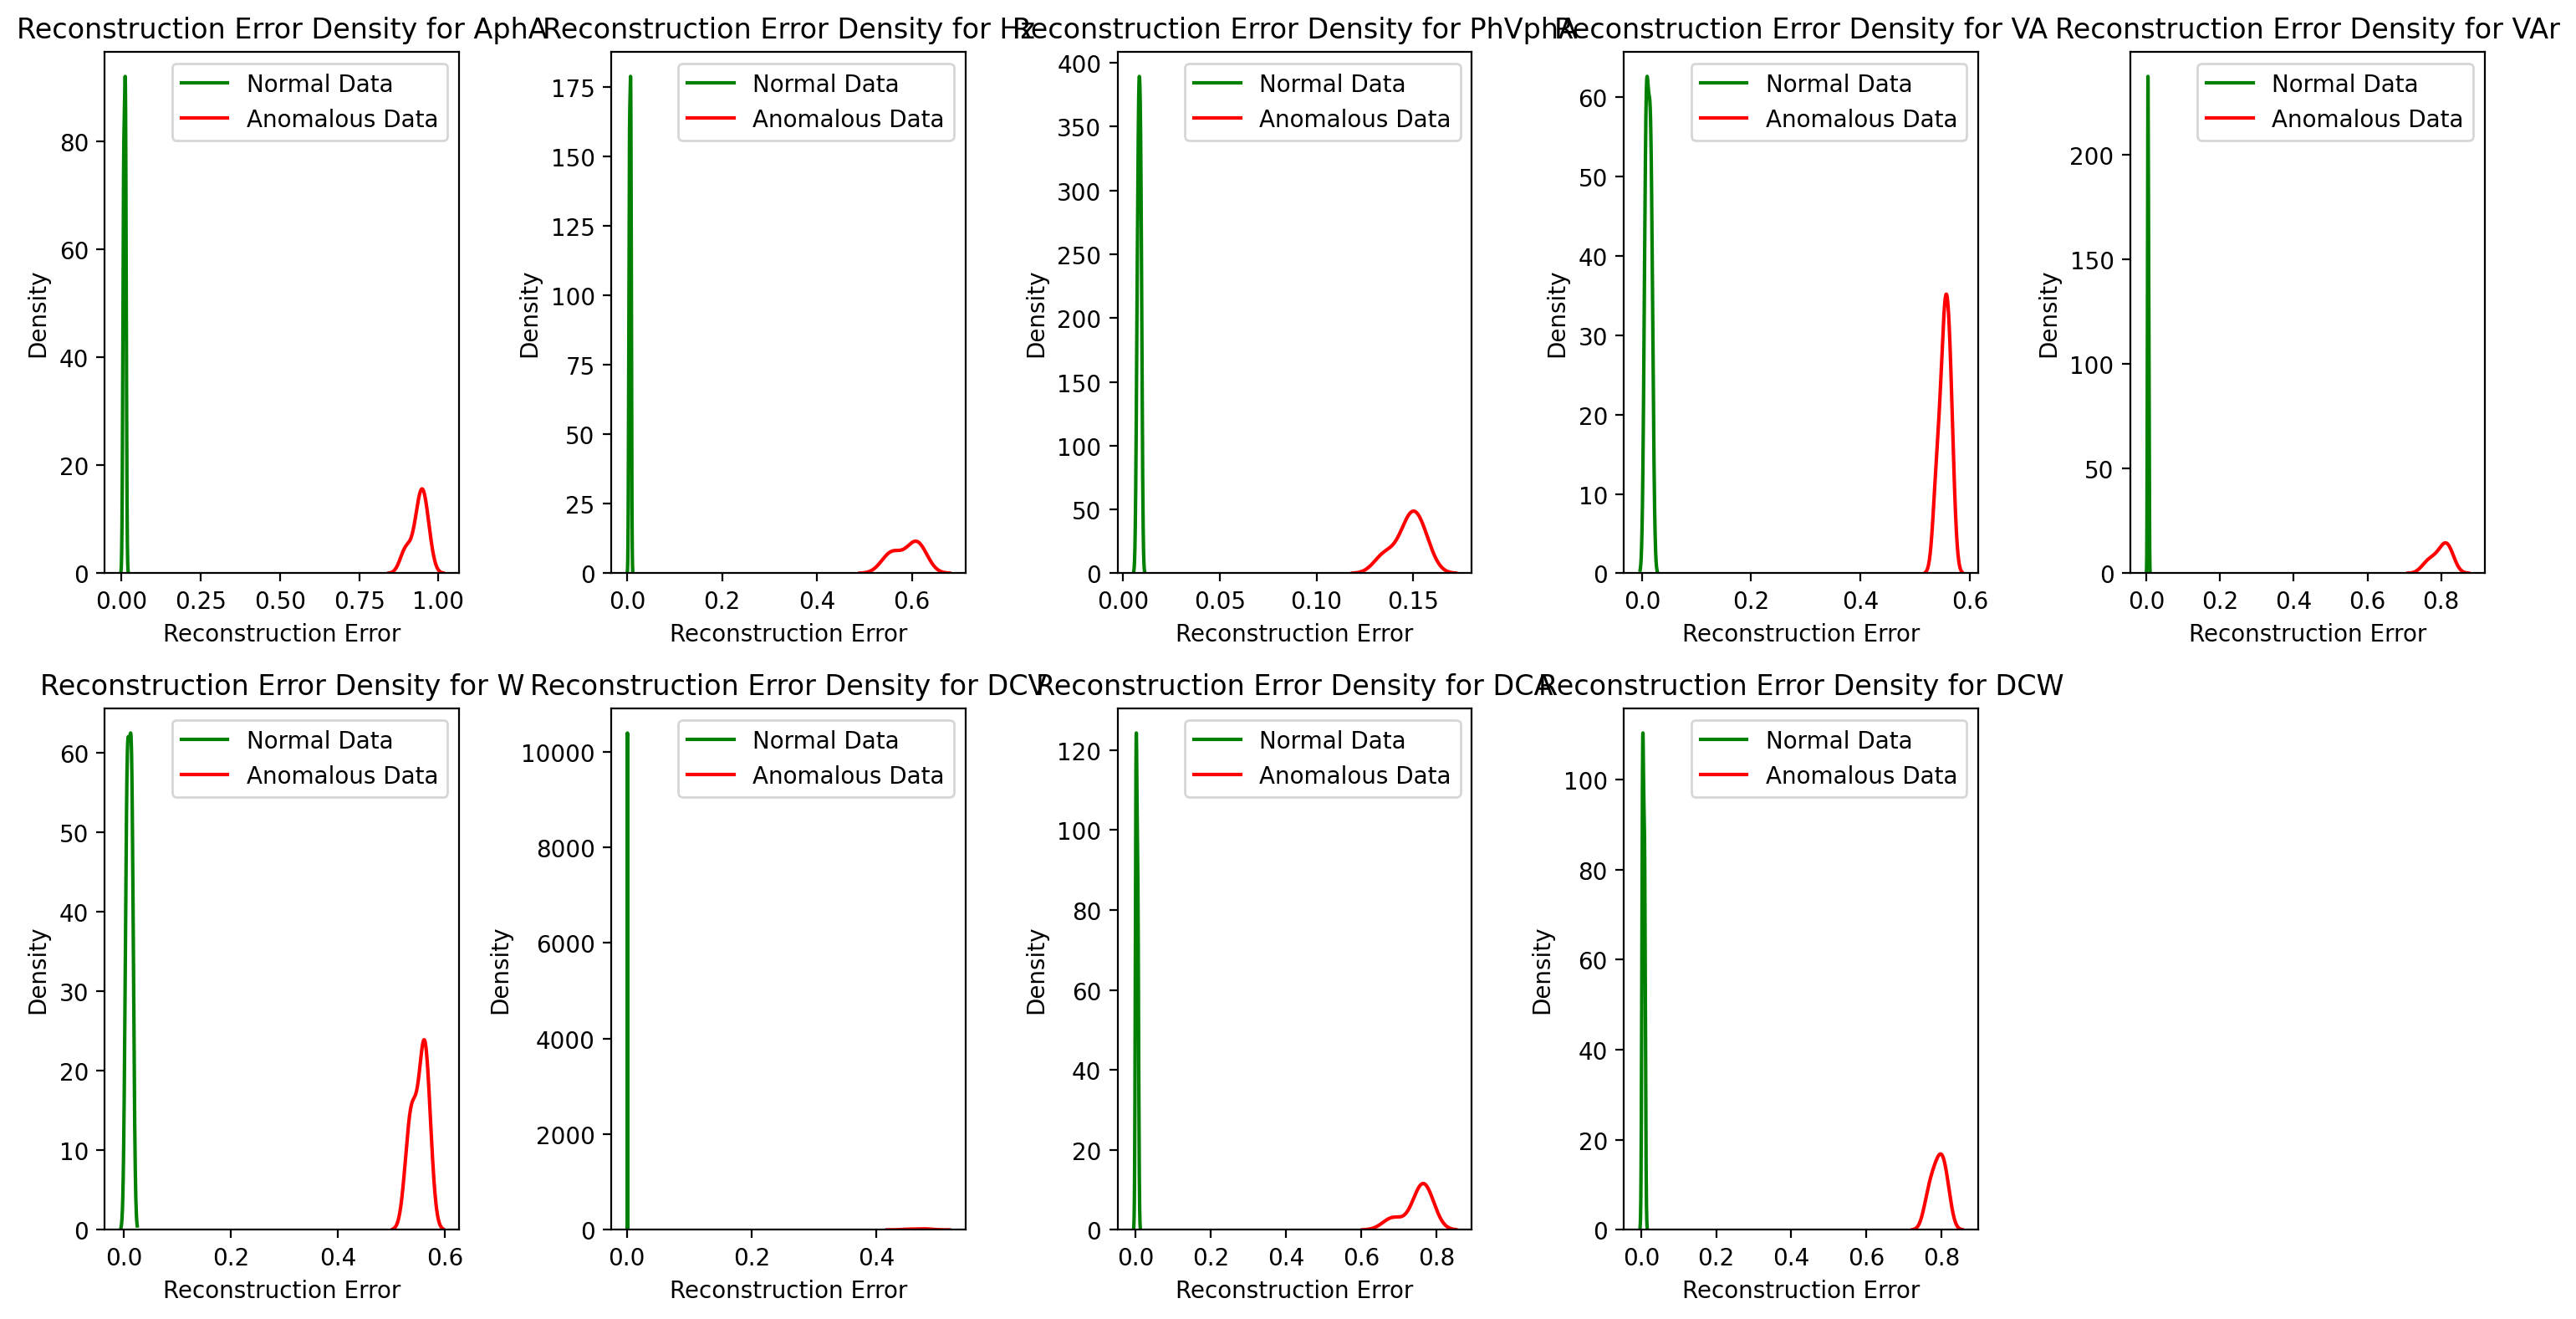

In [68]:
plt.figure(figsize=(15, 8))

for i in range(num_features):
    plt.subplot(2, (num_features + 1) // 2, i + 1)
    sns.kdeplot(reconstruction_error_normal[:, i], label="Normal Data", color='green')
    sns.kdeplot(reconstruction_error_anomalous[:, i], label="Anomalous Data", color='red')
    plt.title(f'Reconstruction Error Density for {feature_names[i]}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


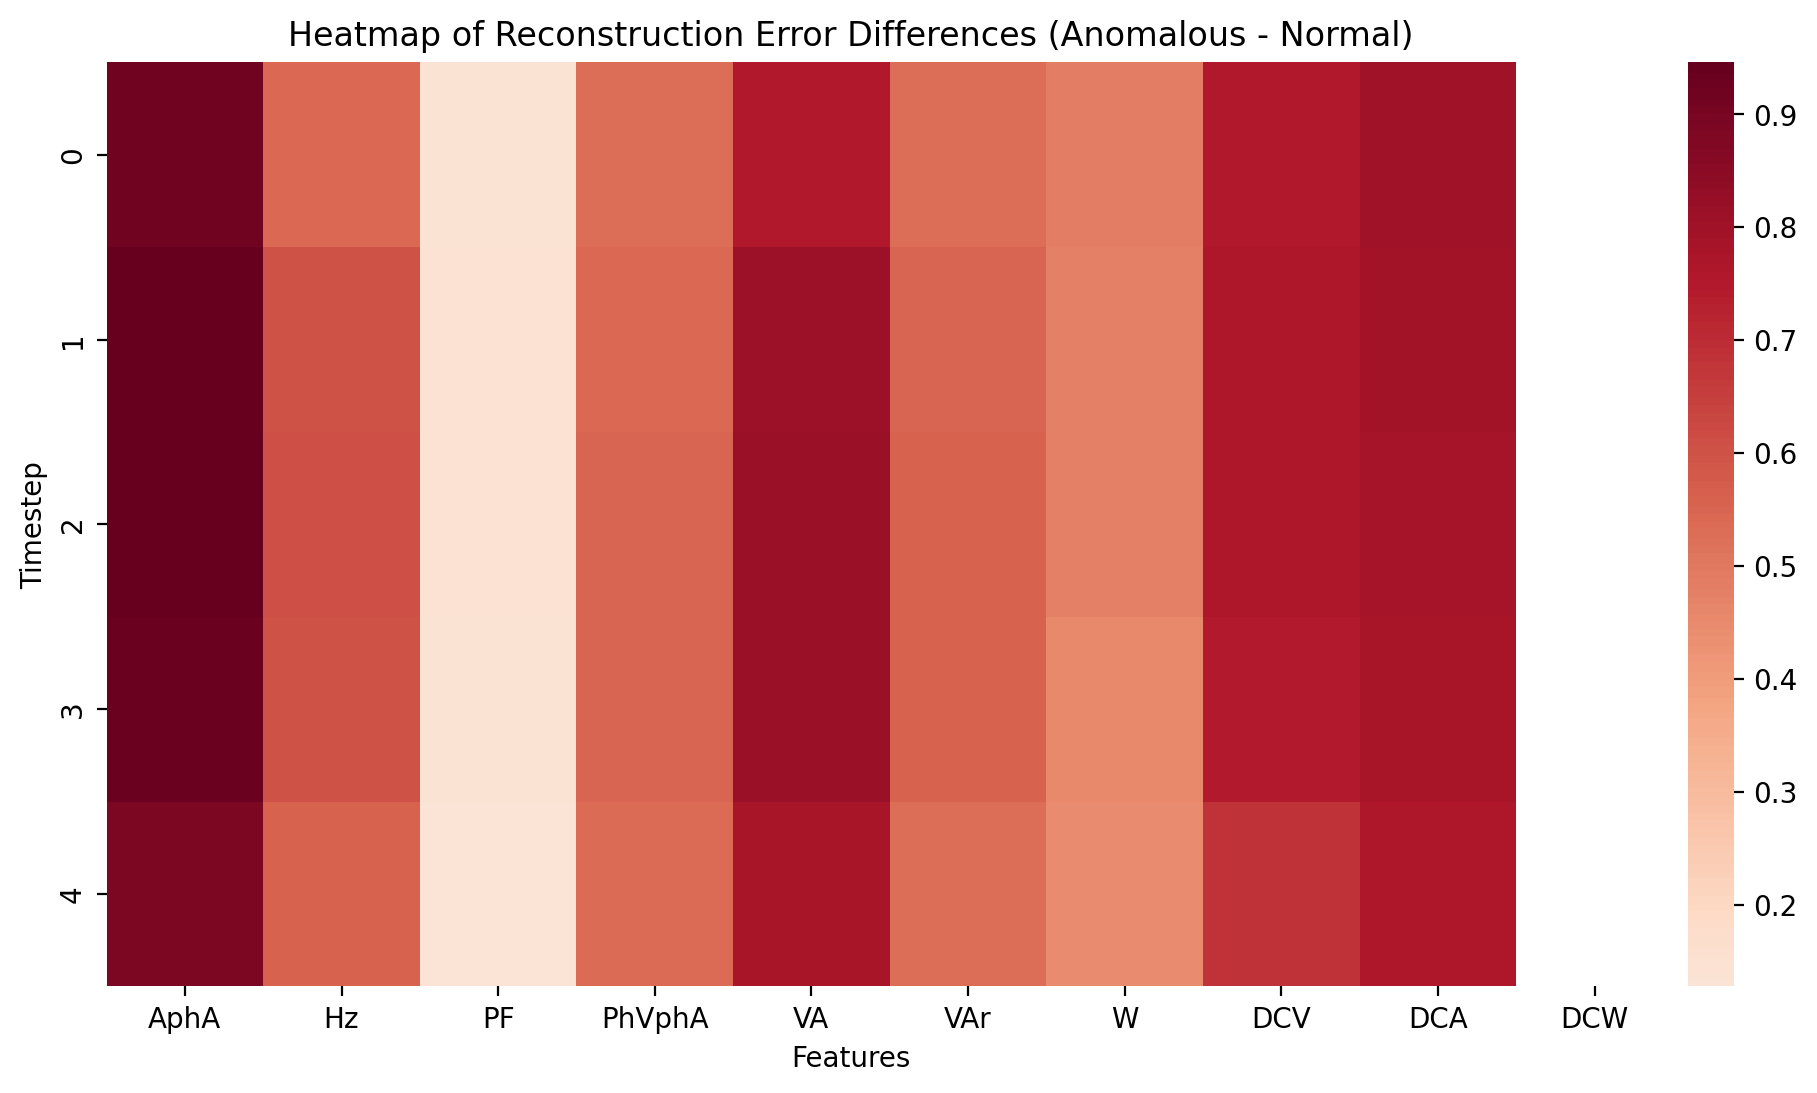

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming feature_names is a list of your feature names
feature_names = ["AphA", "Hz", "PF", "PhVphA", "VA", "VAr", "W", "DCV", "DCA", "DCW"]

# Calculate the error difference between anomalous and normal data
error_difference = reconstruction_error_anomalous - reconstruction_error_normal

plt.figure(figsize=(12, 6))

# Create the heatmap with feature names on the x-axis
sns.heatmap(error_difference, cmap="RdBu_r", center=0, cbar=True, annot=False, xticklabels=feature_names)

plt.title('Heatmap of Reconstruction Error Differences (Anomalous - Normal)')
plt.xlabel('Features')
plt.ylabel('Timestep')
plt.show()


In [70]:

X_corrupted

array([[[-0.34324964,  0.68429326,  0.95414712, ...,  0.19156705,
         -0.39316842, -0.2549338 ],
        [-0.34324964,  0.68429326,  0.95414712, ...,  0.19156705,
         -0.39316842, -0.2549338 ],
        [-0.34324964,  0.68429326,  0.95414712, ...,  0.19156705,
         -0.39316842, -0.2549338 ],
        [-0.34324964,  0.68429326,  0.95414712, ...,  0.21926773,
         -0.39530525, -0.25646788],
        [-0.34338318,  0.68416988,  0.95455761, ...,  0.38275984,
         -0.39583945, -0.25615791]],

       [[-0.34324964,  0.68429326,  0.95414712, ...,  0.19156705,
         -0.39316842, -0.2549338 ],
        [-0.34324964,  0.68429326,  0.95414712, ...,  0.19156705,
         -0.39316842, -0.2549338 ],
        [-0.34324964,  0.68429326,  0.95414712, ...,  0.21926773,
         -0.39530525, -0.25646788],
        [-0.34338318,  0.68416988,  0.95455761, ...,  0.38275984,
         -0.39583945, -0.25615791],
        [-0.34351673,  0.6840465 ,  0.9549681 , ...,  0.38275984,
         -0.39

## Precision, recall and f1 score


In [71]:
def calculate_mae(data, reconstructions):
    """Calculate the Mean Absolute Error for each sample."""
    return np.mean(np.abs(data - reconstructions), axis=1)


In [72]:
normal_mae_threshold = np.mean(calculate_mae(X, autoencoder.predict(X)))
corrupted_mae_threshold = np.mean(calculate_mae(X_corrupted, autoencoder.predict(X_corrupted)))
print(f"normal data MAE threshold:{normal_mae_threshold}")
print(f"corrupted data MAE threshold: {corrupted_mae_threshold}")

18900/18900 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step
normal data MAE threshold:0.005689278528958939
corrupted data MAE threshold: 0.3432290829986098


In [73]:
def calculate_precision_recall_f1(model, corrupted_data, true_anomalies, threshold):
    """
    Calculate precision, recall, and F1 score for the model predictions on corrupted data using
    a specified threshold for the reconstruction error.
    
    Parameters:
    - model: Trained autoencoder model
    - corrupted_data: Numpy array of corrupted data (shape: [num_samples, num_features])
    - true_anomalies: Numpy array of true anomalies (binary: 0 for normal, 1 for anomaly)
    - threshold: Threshold value for detecting anomalies
    
    Returns:
    - precision: Precision score
    - recall: Recall score
    - f1: F1 score
    """

    # Predict on corrupted data
    corrupted_reconstructions = model.predict(corrupted_data)

    # Calculate MAE for corrupted data
    corrupted_mae = calculate_mae(corrupted_data, corrupted_reconstructions)

    # Predict anomalies based on the provided threshold
    predicted_anomalies = (corrupted_mae > threshold).astype(int)

    # Ensure true_anomalies and predicted_anomalies are both binary arrays of the same shape
    true_anomalies = np.array(true_anomalies).flatten().astype(int)
    predicted_anomalies = np.array(predicted_anomalies).flatten().astype(int)

    # Ensure both arrays have the same length
    min_len = min(len(true_anomalies), len(predicted_anomalies))
    true_anomalies = true_anomalies[:min_len]
    predicted_anomalies = predicted_anomalies[:min_len]

    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_anomalies, predicted_anomalies, average='binary')
    
    return precision, recall, f1

# Calculate precision, recall, and F1 using the mean normal MAE as the threshold
normal_mae_threshold = np.mean(calculate_mae(X, autoencoder.predict(X)))
precision, recall, f1 = calculate_precision_recall_f1(autoencoder, X_corrupted, corrupted_data['Target'], normal_mae_threshold)
print(f"Precision with normal data MAE threshold: {precision:.4f}")
print(f"Recall with normal data MAE threshold: {recall:.4f}")
print(f"F1 Score with normal data MAE threshold: {f1:.4f}")

# Calculate precision, recall, and F1 using the mean corrupted MAE as the threshold
corrupted_mae_threshold = np.mean(calculate_mae(X_corrupted, autoencoder.predict(X_corrupted)))
precision, recall, f1 = calculate_precision_recall_f1(autoencoder, X_corrupted, corrupted_data['Target'], corrupted_mae_threshold)
print(f"Precision with corrupted data MAE threshold: {precision:.4f}")
print(f"Recall with corrupted data MAE threshold: {recall:.4f}")
print(f"F1 Score with corrupted data MAE threshold: {f1:.4f}")


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step
Precision with normal data MAE threshold: 0.1000
Recall with normal data MAE threshold: 0.9972
F1 Score with normal data MAE threshold: 0.1818
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step
Precision with corrupted data MAE threshold: 0.1000
Recall with corrupted data MAE threshold: 0.2978
F1 Score with corrupted data MAE threshold: 0.1498


In [74]:
# Normal data reconstruction error
normal_reconstruction_error = np.mean(np.abs(X - autoencoder.predict(X)), axis=1)

# Corrupted data reconstruction error
corrupted_reconstruction_error = np.mean(np.abs(X_corrupted - autoencoder.predict(X_corrupted)), axis=1)


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step


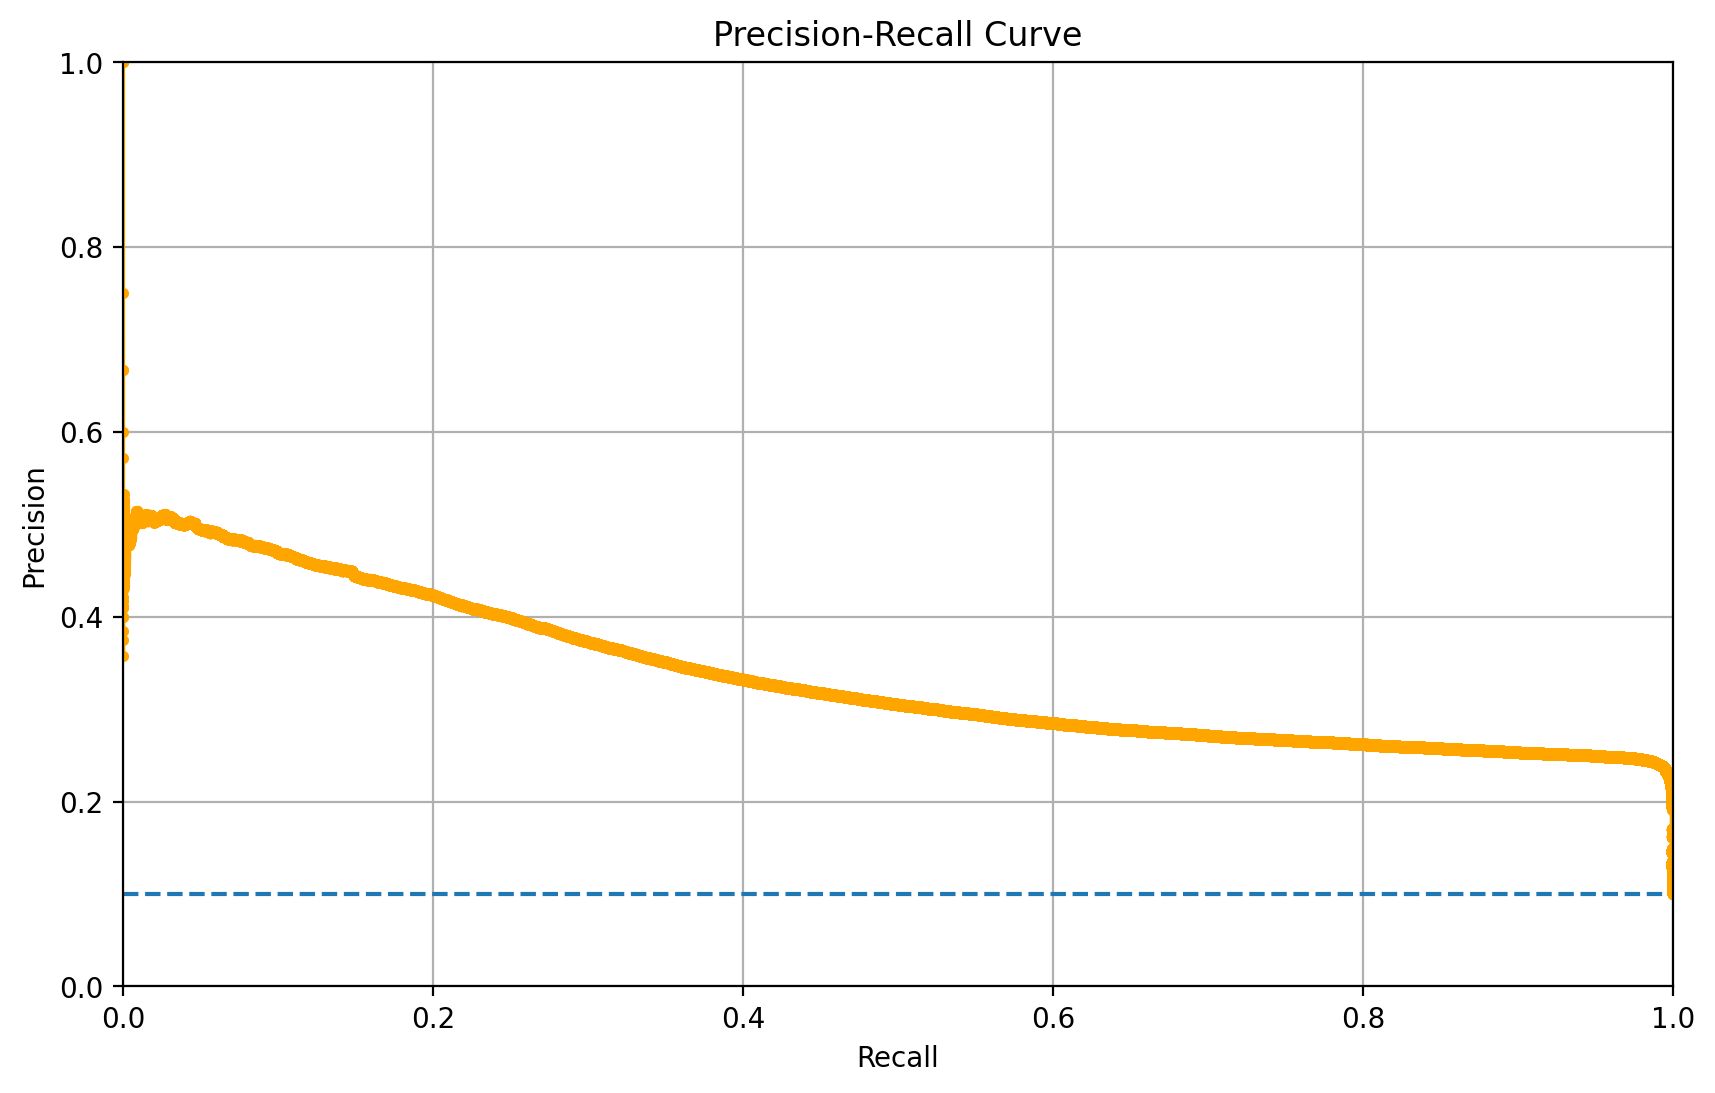

In [75]:
from sklearn.metrics import precision_recall_curve

true_anomalies = corrupted_data['Target'].values.flatten().astype(int)

# Calculate the mean reconstruction error across all features for each sample
corrupted_reconstruction_error = np.mean(corrupted_reconstruction_error, axis=1)

#trimming to the same number of length
min_len = min(len(true_anomalies), len(corrupted_reconstruction_error))
true_anomalies = true_anomalies[:min_len]
corrupted_reconstruction_error = corrupted_reconstruction_error[:min_len]

precision, recall, thresholds = precision_recall_curve(true_anomalies, corrupted_reconstruction_error)


plt.figure(figsize=(10, 6))
no_skill = len(true_anomalies[true_anomalies==1]) / len(true_anomalies)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision,marker='.', color ='orange', label='P-R curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()



In [76]:
 
true_anomalies = corrupted_data['Target'].values


def find_best_threshold(normal_error, corrupted_error, true_anomalies, step=0.001):
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    # Search for best threshold between minimum and maximum reconstruction error
    for threshold in np.arange(np.min(normal_error), np.max(corrupted_error), step):
        # Predicted anomalies based on threshold
        predicted_anomalies = (corrupted_error > threshold).astype(int)
        
        # Ensure true and predicted anomalies have the same length
        min_len = min(len(true_anomalies), len(predicted_anomalies))
        true_anomalies_trimmed = true_anomalies[:min_len]
        predicted_anomalies_trimmed = predicted_anomalies[:min_len]

        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(true_anomalies_trimmed, predicted_anomalies_trimmed, average='binary')

        # Check if F1 score is the best so far
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_f1, best_precision, best_recall


In [77]:
#normal best threshold
best_threshold, best_f1, best_precision, best_recall = find_best_threshold(normal_reconstruction_error, corrupted_reconstruction_error, true_anomalies)
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")


Best Threshold: 0.39905768332266106
Best F1 Score: 0.39567135874950365
Best Precision: 0.25508895502961976
Best Recall: 0.8814464524876403


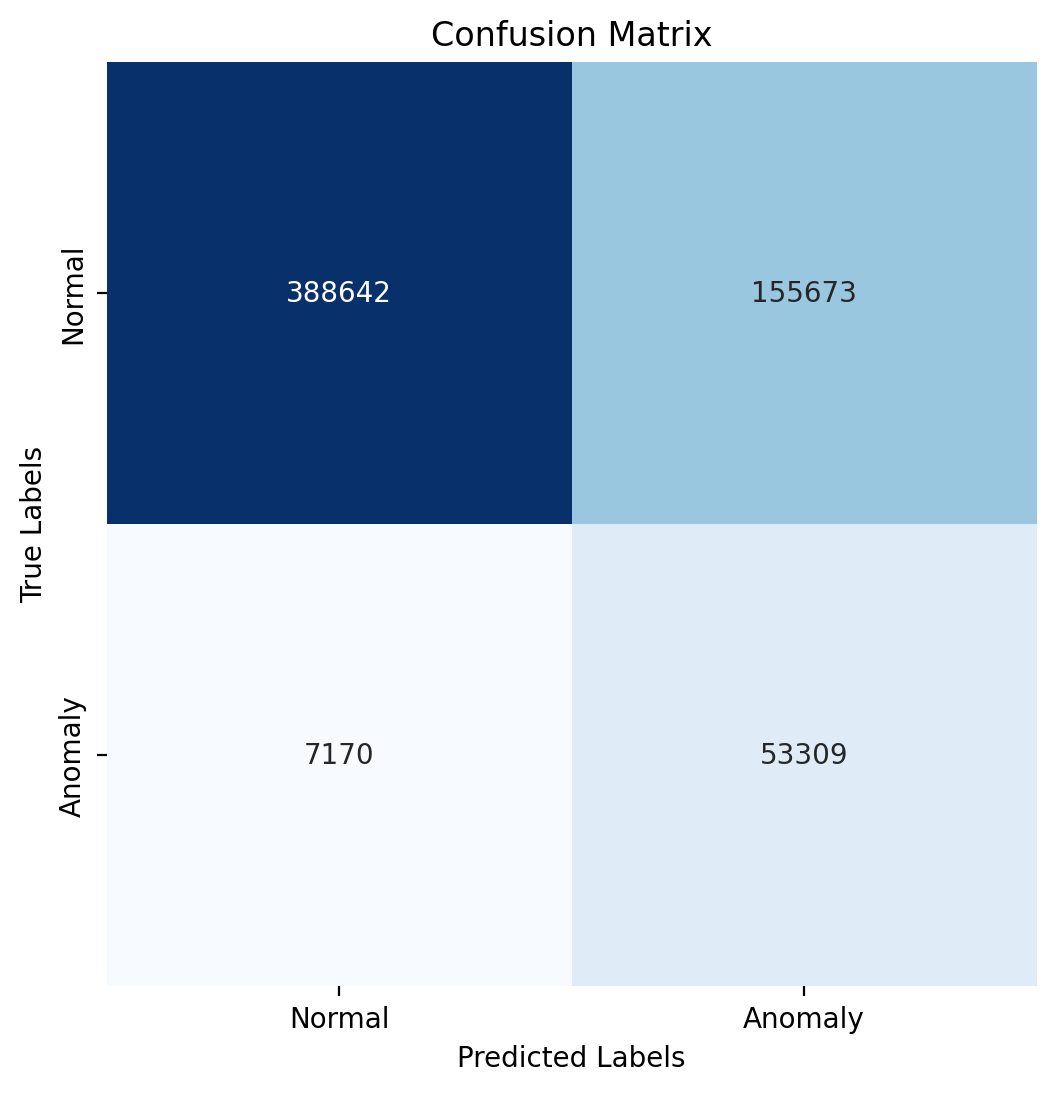

In [78]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_anomalies, predicted_anomalies):
    """
    Plot the confusion matrix for the true and predicted anomalies.
    
    Parameters:
    - true_anomalies: Array of true binary anomaly labels (0 for normal, 1 for anomaly)
    - predicted_anomalies: Array of predicted binary anomaly labels (0 for normal, 1 for anomaly)
    """
    
    cm = confusion_matrix(true_anomalies, predicted_anomalies)
    
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Normal', 'Anomaly'], 
                yticklabels=['Normal', 'Anomaly'])
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

threshold=best_threshold
true_anomalies = corrupted_data['Target'].values.flatten().astype(int)
predicted_anomalies = (corrupted_reconstruction_error > threshold).astype(int)
min_len = min(len(true_anomalies), len(predicted_anomalies))
true_anomalies = true_anomalies[:min_len]
predicted_anomalies= predicted_anomalies[:min_len]
# Plot confusion matrix
plot_confusion_matrix(true_anomalies, predicted_anomalies)





EXTRACTING RECONSTRUCTION ERROR FOR THE LAST TIMESTEP

In [79]:
def calculate_mae_last_timestep(data, reconstructions):
    """Calculate the Mean Absolute Error for the last timestep of each sequence."""
    # Extract the last timestep from both data and reconstructions
    data_last_timestep = data[:, -1, :]  # Shape: (num_sequences, num_features)
    reconstructions_last_timestep = reconstructions[:, -1, :]  # Shape: (num_sequences, num_features)
    
    # Calculate MAE for the last timestep
    return np.mean(np.abs(data_last_timestep - reconstructions_last_timestep), axis=1)


In [80]:
normal_mae_threshold_last = np.mean(calculate_mae_last_timestep(X,autoencoder.predict(X)))
corrupted_mae_threshold_last = np.mean(calculate_mae_last_timestep(X_corrupted,autoencoder.predict(X_corrupted)))
print(f"normal data MAE threshold:{normal_mae_threshold_last}")
print(f"corrupted data MAE threshold: {corrupted_mae_threshold_last}")

18900/18900 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step
normal data MAE threshold:0.00566827602147422
corrupted data MAE threshold: 0.3384378417745866


In [81]:
# Calculate precision, recall, and F1 using the mean normal MAE as the threshold
normal_mae_threshold_last = np.mean(calculate_mae_last_timestep(X,autoencoder.predict(X)))
precision, recall, f1 = calculate_precision_recall_f1(autoencoder, X_corrupted, corrupted_data['Target'], normal_mae_threshold_last)
print(f"Precision with normal data MAE threshold: {precision:.4f}")
print(f"Recall with normal data MAE threshold: {recall:.4f}")
print(f"F1 Score with normal data MAE threshold: {f1:.4f}")

# Calculate precision, recall, and F1 using the mean corrupted MAE as the threshold
corrupted_mae_threshold_last = np.mean(calculate_mae_last_timestep(X_corrupted,autoencoder.predict(X_corrupted)))
precision, recall, f1 = calculate_precision_recall_f1(autoencoder, X_corrupted, corrupted_data['Target'], corrupted_mae_threshold_last)
print(f"Precision with corrupted data MAE threshold: {precision:.4f}")
print(f"Recall with corrupted data MAE threshold: {recall:.4f}")
print(f"F1 Score with corrupted data MAE threshold: {f1:.4f}")


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step
Precision with normal data MAE threshold: 0.1000
Recall with normal data MAE threshold: 0.9972
F1 Score with normal data MAE threshold: 0.1818
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step
Precision with corrupted data MAE threshold: 0.1001
Recall with corrupted data MAE threshold: 0.2996
F1 Score with corrupted data MAE threshold: 0.1501


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step


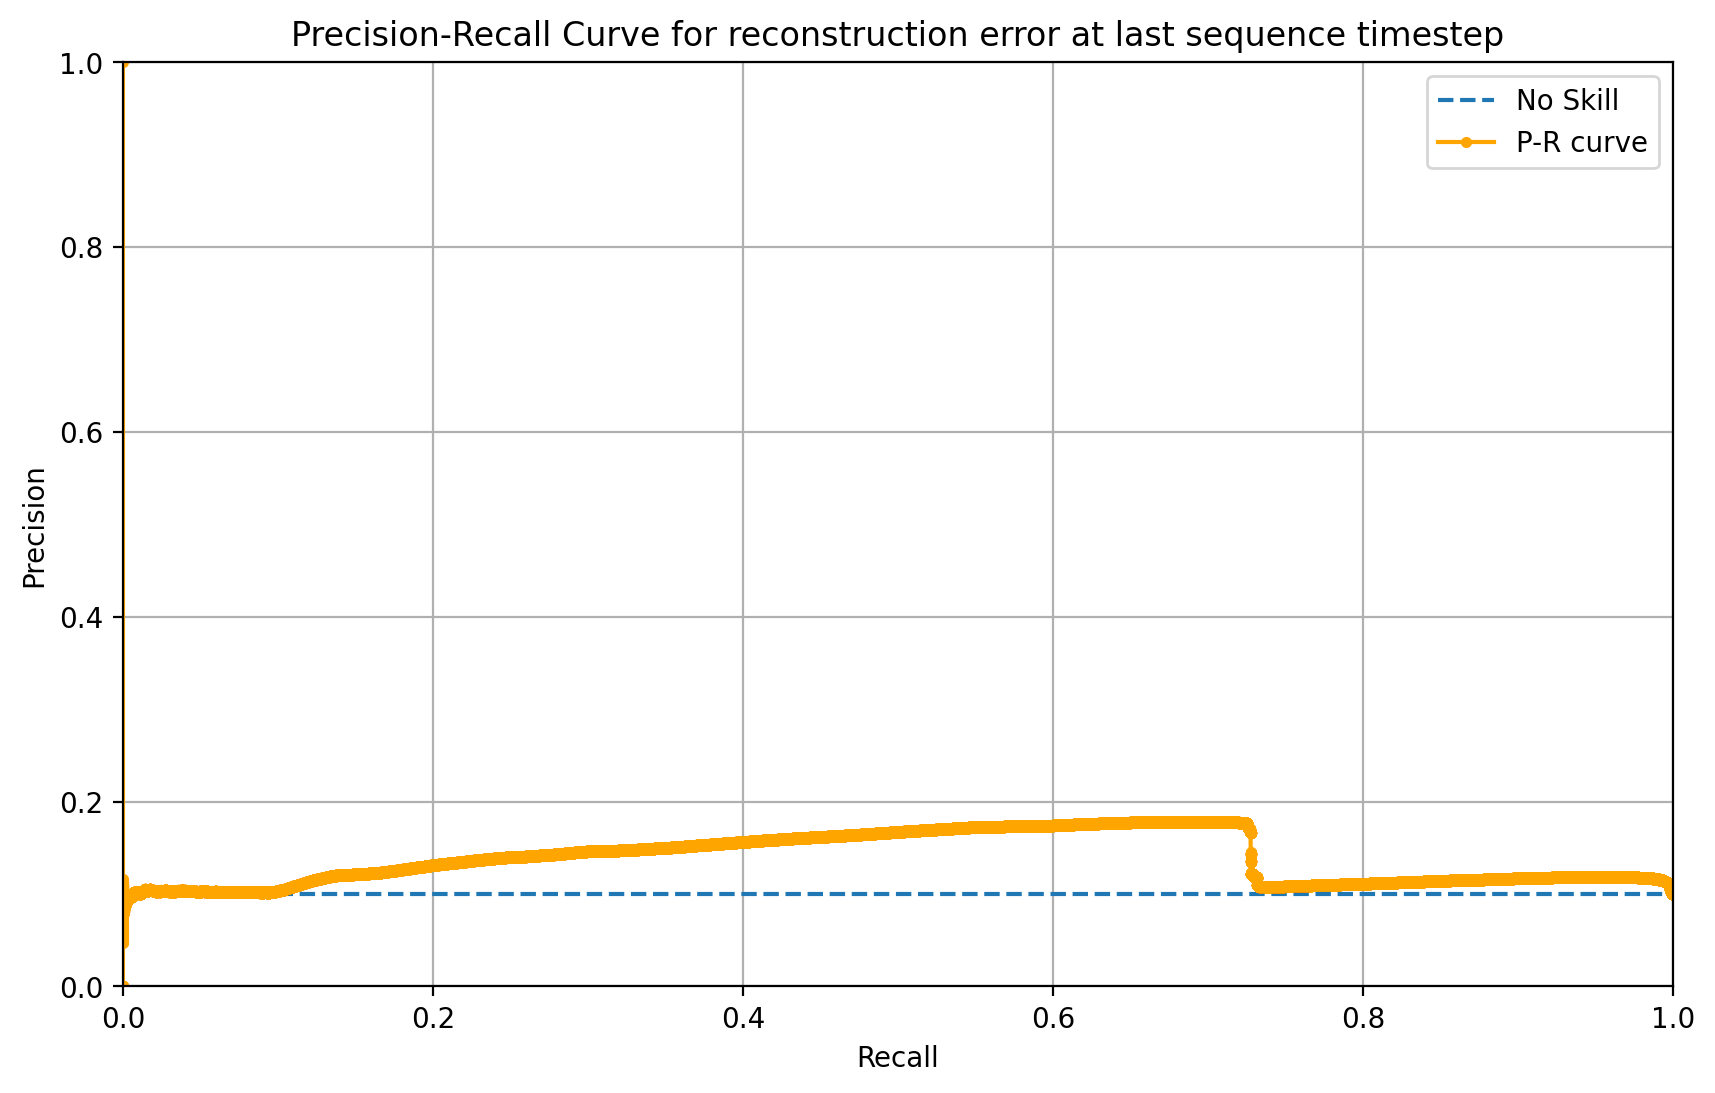

In [82]:
# Calculate MAE for the last timestep
corrupted_mae_last_timestep = calculate_mae_last_timestep(X_corrupted,autoencoder.predict(X_corrupted))

# Ensure true_anomalies has the correct length to match corrupted_mae_last_timestep
min_len = min(len(true_anomalies), len(corrupted_mae_last_timestep))
true_anomalies = true_anomalies[:min_len]
corrupted_mae_last_timestep = corrupted_mae_last_timestep[:min_len]

# Compute precision, recall, and thresholds
precision_last, recall_last, thresholds_last = precision_recall_curve(true_anomalies, corrupted_mae_last_timestep)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
no_skill = len(true_anomalies[true_anomalies==1]) / len(true_anomalies)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall_last, precision_last, marker='.', color='orange', label='P-R curve')
plt.title('Precision-Recall Curve for reconstruction error at last sequence timestep')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [83]:
normal_reconstruction_error_last = calculate_mae_last_timestep(X,autoencoder.predict(X))
corrupted_reconstruction_error_last=calculate_mae_last_timestep(X_corrupted,autoencoder.predict(X_corrupted))


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step


In [84]:
best_threshold, best_f1, best_precision, best_recall = find_best_threshold(normal_reconstruction_error_last, corrupted_reconstruction_error_last, true_anomalies)
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")

Best Threshold: 0.19451167471867617
Best F1 Score: 0.2847089037139245
Best Precision: 0.17786292284976615
Best Recall: 0.7130574248912845


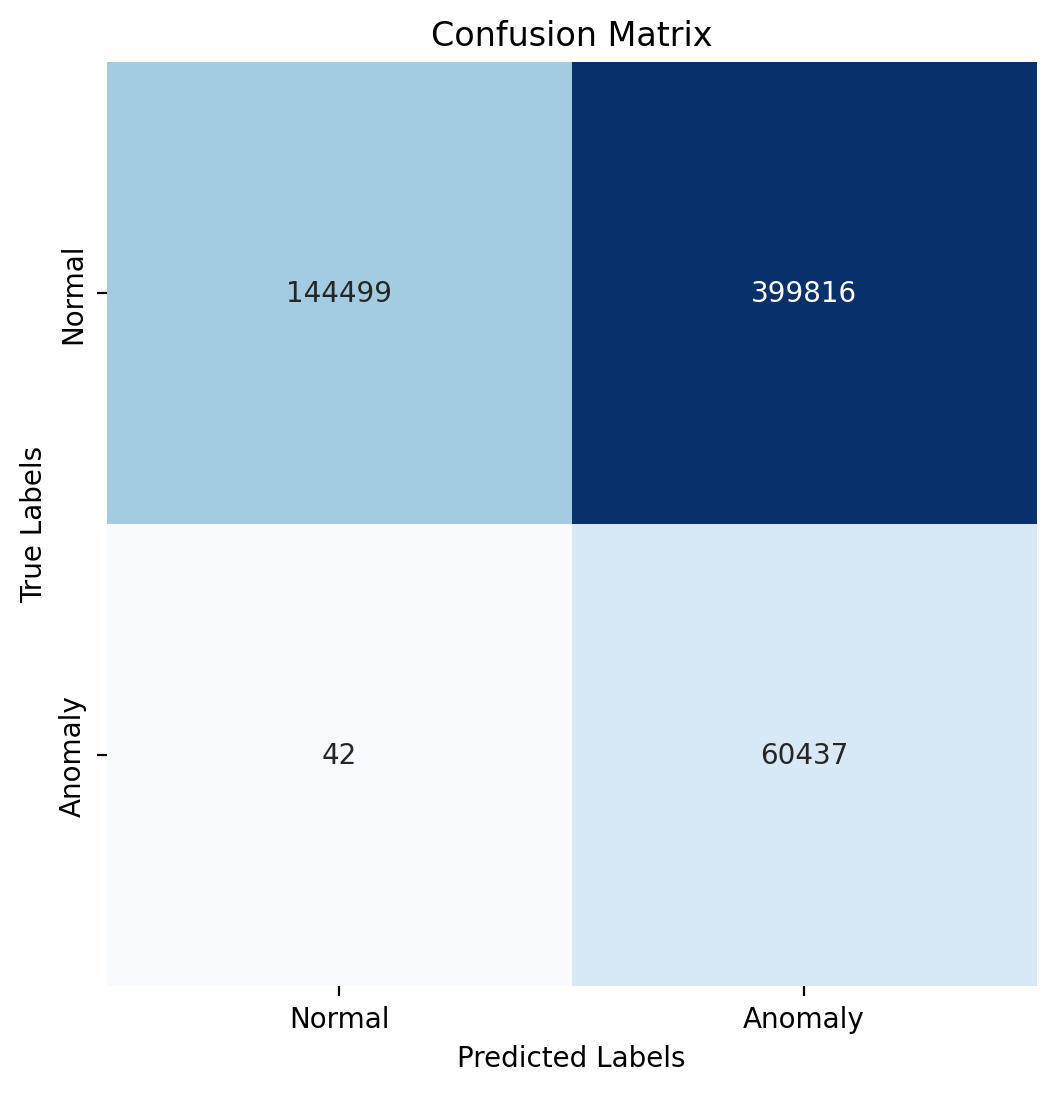

In [85]:
threshold=best_threshold
true_anomalies = corrupted_data['Target'].values.flatten().astype(int)
predicted_anomalies = (corrupted_reconstruction_error > threshold).astype(int)
min_len = min(len(true_anomalies), len(predicted_anomalies))
true_anomalies = true_anomalies[:min_len]
predicted_anomalies= predicted_anomalies[:min_len]
# Plot confusion matrix
plot_confusion_matrix(true_anomalies, predicted_anomalies)


# exponential weighted average

In [86]:
def calculate_exponential_weighted_mae(data, reconstructions, alpha=0.9):
    """
    Calculate the exponential weighted MAE for each sequence.
    
    Parameters:
    - data: Original data sequences (shape: [num_sequences, sequence_length, num_features])
    - reconstructions: Reconstructed data sequences (shape: [num_sequences, sequence_length, num_features])
    - alpha: Smoothing factor (between 0 and 1). Higher alpha gives more weight to recent timesteps.
    
    Returns:
    - exp_weighted_mae: Exponentially weighted MAE for each sequence (shape: [num_sequences])
    """
    # Calculate the absolute errors for each timestep in each sequence
    abs_errors = np.abs(data - reconstructions)  # Shape: (num_sequences, sequence_length, num_features)
    
    # Initialize an array to store the exponential weighted errors
    exp_weighted_mae = np.zeros(abs_errors.shape[0])  # Shape: (num_sequences)
    
    # Loop through each sequence and compute the weighted average of the errors
    for i in range(abs_errors.shape[0]):
        sequence_errors = np.mean(abs_errors[i], axis=1)  # Average over features for each timestep
        exp_weighted_mae[i] = np.average(sequence_errors, weights=np.exp(np.arange(sequence_errors.shape[0]) * (1 - alpha)))
    
    return exp_weighted_mae


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step


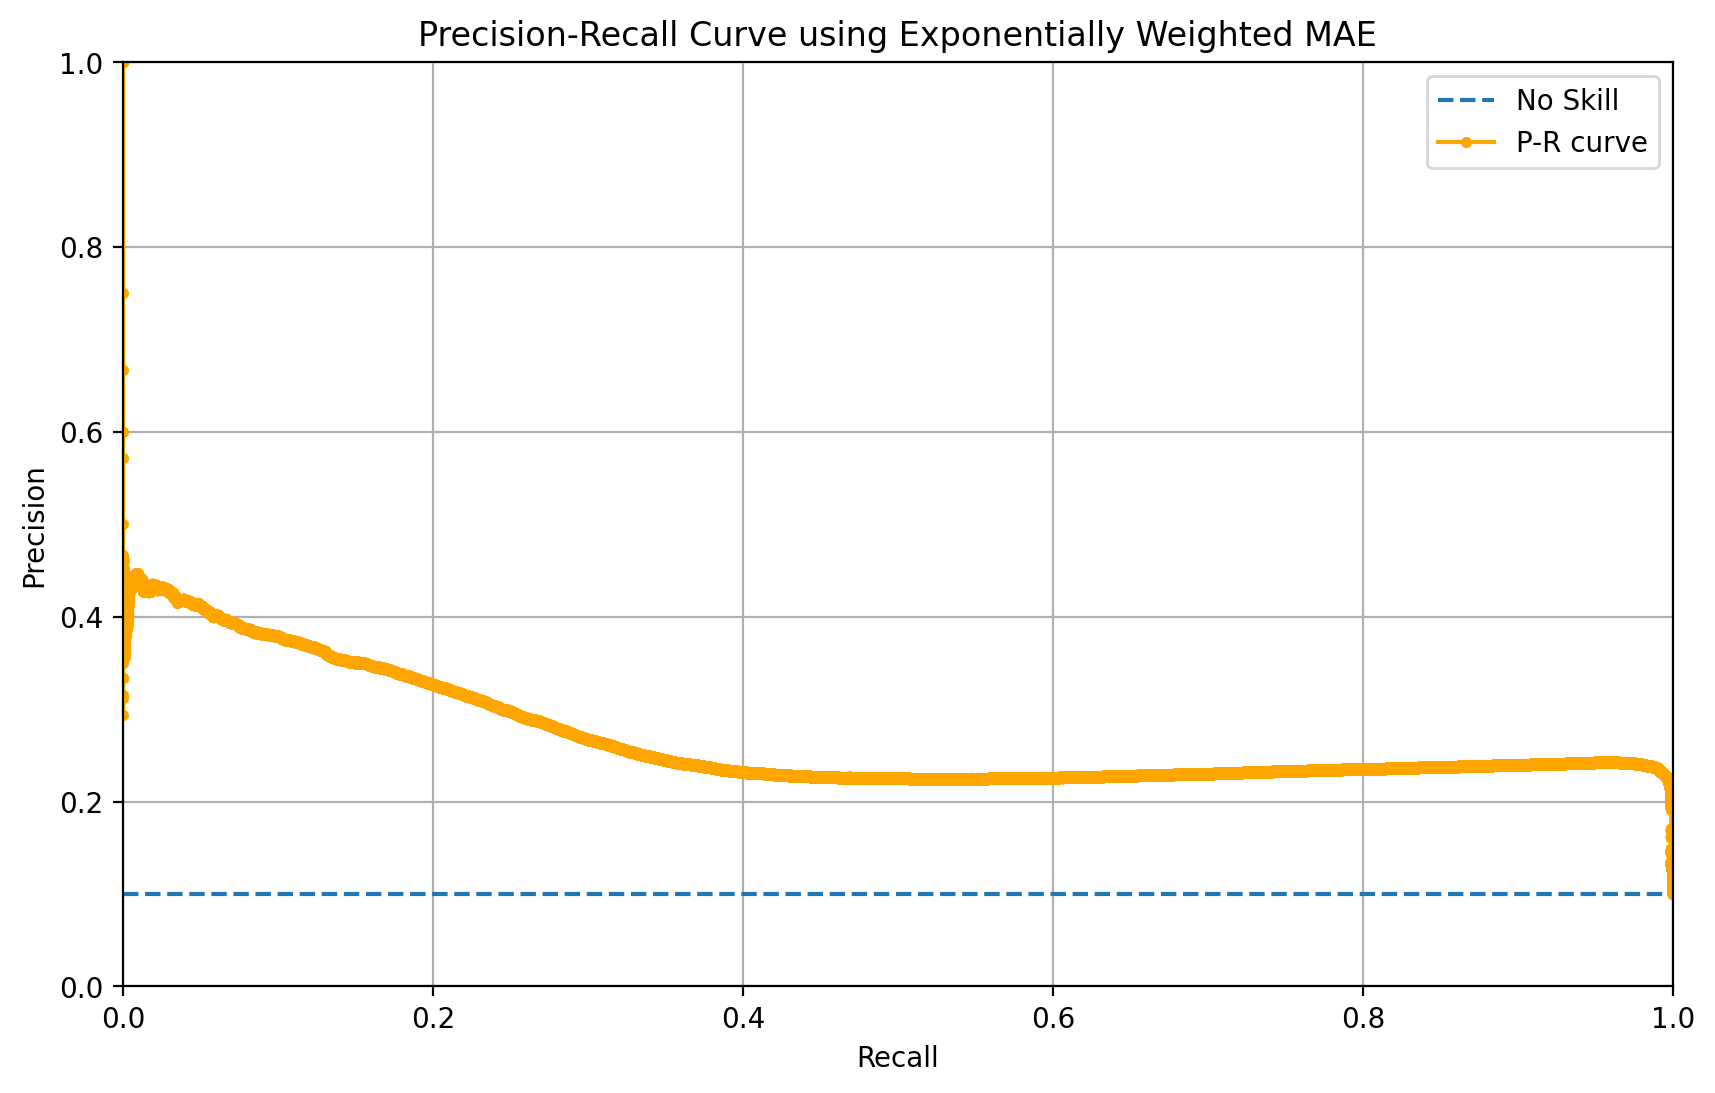

In [87]:
# Predict the reconstructions for the corrupted data
corrupted_reconstructions = autoencoder.predict(X_corrupted)

# Calculate the exponentially weighted MAE for corrupted data
corrupted_mae_exp_weighted = calculate_exponential_weighted_mae(X_corrupted, corrupted_reconstructions, alpha=0.9)

# Ensure true_anomalies has the correct length
min_len = min(len(corrupted_data['Target']), len(corrupted_mae_exp_weighted))
true_anomalies = corrupted_data['Target'][:min_len].values
corrupted_mae_exp_weighted = corrupted_mae_exp_weighted[:min_len]
from sklearn.metrics import precision_recall_curve

# Calculate the precision-recall curve
precision_exp_weighted, recall_exp_weighted, thresholds_exp_weighted = precision_recall_curve(true_anomalies, corrupted_mae_exp_weighted)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
no_skill = len(true_anomalies[true_anomalies == 1]) / len(true_anomalies)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall_exp_weighted, precision_exp_weighted, marker='.', color='orange', label='P-R curve')
plt.title('Precision-Recall Curve using Exponentially Weighted MAE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [88]:
normal_reconstruction_error_exp =calculate_exponential_weighted_mae(X, autoencoder.predict(X), alpha=0.9)
corrupted_reconstruction_error_exp=calculate_exponential_weighted_mae(X_corrupted, corrupted_reconstructions, alpha=0.9)


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step


In [89]:
best_threshold, best_f1, best_precision, best_recall = find_best_threshold(normal_reconstruction_error_exp, corrupted_reconstruction_error_exp, true_anomalies)
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")

Best Threshold: 0.29632533713792636
Best F1 Score: 0.3874521612819781
Best Precision: 0.24233058845491692
Best Recall: 0.9658724515947684


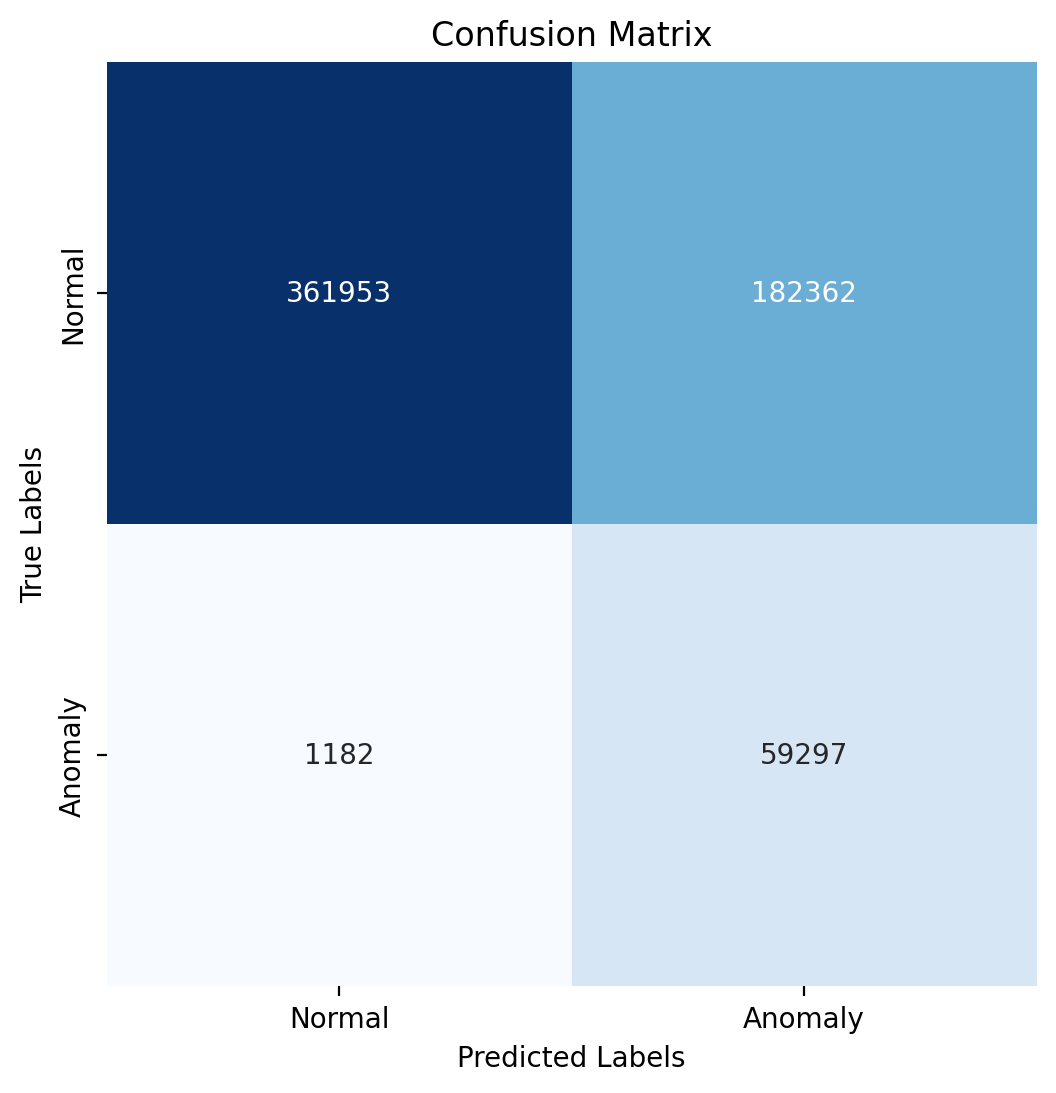

In [90]:
threshold=best_threshold
true_anomalies = corrupted_data['Target'].values.flatten().astype(int)
predicted_anomalies = (corrupted_reconstruction_error > threshold).astype(int)
min_len = min(len(true_anomalies), len(predicted_anomalies))
true_anomalies = true_anomalies[:min_len]
predicted_anomalies= predicted_anomalies[:min_len]
# Plot confusion matrix
plot_confusion_matrix(true_anomalies, predicted_anomalies)


In [91]:
true_anomalies.shape

(604794,)

In [92]:
corrupted_reconstruction_error.shape

(604794,)

## Timestep Binary Decision Level

In [93]:
def binary_anomaly_decisions(reconstruction_errors, threshold):
    """
    Generate binary anomaly decisions based on reconstruction errors and a threshold.
    Parameters:
    - reconstruction_errors: numpy array of shape (num_sequences, sequence_length)
    - threshold: float, threshold for detecting anomalies
    Returns:
    - binary_decisions: numpy array of shape (num_sequences, sequence_length)
    """
    return (reconstruction_errors > threshold).astype(int)



In [94]:
def weighted_sequence_decision(timestep_decisions, weights):
    """
    Generate a higher-level decision for each sequence based on weighted sum of binary decisions.
    
    Parameters:
    - timestep_decisions: numpy array of shape (num_sequences, sequence_length)
    - weights: numpy array of shape (sequence_length), weights for each timestep87
    
    Returns:
    - sequence_decisions: numpy array of shape (num_sequences), higher-level decisions for each sequence
    """
    weighted_scores = np.dot(timestep_decisions, weights)
    return (weighted_scores >= 0.5).astype(int)



In [95]:
# Calculate reconstruction errors for each timestep
normal_reconstruction_error_timestep = np.mean(np.abs(X - autoencoder.predict(X)), axis=2)
corrupted_reconstruction_error_timestep = np.mean(np.abs(X_corrupted - autoencoder.predict(X_corrupted)), axis=2)


18900/18900 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step


In [96]:
import tqdm as tqdm

In [97]:
# Define the functions
import numpy as np
import logging
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def binary_anomaly_decisions(reconstruction_errors, threshold):
    return (reconstruction_errors > threshold).astype(int)

def weighted_sequence_decision(timestep_decisions, weights):
    weighted_score = np.dot(timestep_decisions, weights)
    return (weighted_score >= 0.5).astype(int)
    
# Optimizing threshold to maximize F1 score
def find_best_threshold(normal_error, corrupted_error, true_anomalies, weights, step=0.05):
    logging.info("Started finding the best threshold...")
    best_f1, best_threshold, best_precision, best_recall = 0, 0, 0, 0
    true_anomalies = true_anomalies.flatten()

    for threshold in tqdm(np.arange(np.min(normal_error), np.max(corrupted_error), step)):
        timestep_decisions = binary_anomaly_decisions(corrupted_error, threshold)
        
        # Apply weighted decision per sequence
        sequence_decisions = np.array([
            weighted_sequence_decision(seq, weights) for seq in timestep_decisions
        ])  # Expected shape: (num_sequences,)

        # Trim to match length with true_anomalies
        if len(sequence_decisions) != len(true_anomalies):
            min_len = min(len(true_anomalies), len(sequence_decisions))
            true_anomalies_trimmed = true_anomalies[:min_len]
            sequence_decisions_trimmed = sequence_decisions[:min_len]
        else:
            true_anomalies_trimmed, sequence_decisions_trimmed = true_anomalies, sequence_decisions

        # Calculate F1, precision, and recall
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_anomalies_trimmed, sequence_decisions_trimmed, average='binary'
        )

        # Track the best threshold based on F1 score
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
            best_precision, best_recall = precision, recall
            
    logging.info("Finished finding the best threshold")

    return best_threshold, best_f1, best_precision, best_recall

# Calculate reconstruction errors for each timestep
normal_reconstruction_error_timestep = np.mean(np.abs(X - autoencoder.predict(X)), axis=2)
corrupted_reconstruction_error_timestep = np.mean(np.abs(X_corrupted - autoencoder.predict(X_corrupted)), axis=2)

# Example usage
weights = np.array([0.1, 0.15, 0.2, 0.25, 0.3])
best_threshold, best_f1, best_precision, best_recall = find_best_threshold(
    normal_reconstruction_error_timestep, corrupted_reconstruction_error_timestep, true_anomalies, weights
)

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
import numpy as np
import logging
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def binary_anomaly_decisions(reconstruction_errors, threshold):
    return (reconstruction_errors > threshold).astype(int)

def weighted_sequence_decision(timestep_decisions, weights):
    weighted_score = np.dot(timestep_decisions, weights)
    return (weighted_score >= 0.5).astype(int)
    
# Optimizing threshold to maximize F1 score
def find_best_threshold(normal_error, corrupted_error, true_anomalies, weights, step=0.05):
    logging.info("Started finding the best threshold...")
    best_f1, best_threshold, best_precision, best_recall = 0, 0, 0, 0
    true_anomalies = true_anomalies.flatten()

    for threshold in tqdm(np.arange(np.min(normal_error), np.max(corrupted_error), step)):
        timestep_decisions = binary_anomaly_decisions(corrupted_error, threshold)
        
        # Apply weighted decision per sequence
        sequence_decisions = np.array([
            weighted_sequence_decision(seq, weights) for seq in timestep_decisions
        ])  # Expected shape: (num_sequences,)

        # Trim to match length with true_anomalies
        if len(sequence_decisions) != len(true_anomalies):
            min_len = min(len(true_anomalies), len(sequence_decisions))
            true_anomalies_trimmed = true_anomalies[:min_len]
            sequence_decisions_trimmed = sequence_decisions[:min_len]
        else:
            true_anomalies_trimmed, sequence_decisions_trimmed = true_anomalies, sequence_decisions

        # Calculate F1, precision, and recall
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_anomalies_trimmed, sequence_decisions_trimmed, average='binary'
        )

        # Track the best threshold based on F1 score
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
            best_precision, best_recall = precision, recall
            
    logging.info("Finished finding the best threshold")

    return best_threshold, best_f1, best_precision, best_recall

# Calculate reconstruction errors for each timestep
normal_reconstruction_error_timestep = np.mean(np.abs(X - autoencoder.predict(X)), axis=2)
corrupted_reconstruction_error_timestep = np.mean(np.abs(X_corrupted - autoencoder.predict(X_corrupted)), axis=2)

# Example usage
weights = np.array([0.1, 0.15, 0.2, 0.25, 0.3])
best_threshold, best_f1, best_precision, best_recall = find_best_threshold(
    normal_reconstruction_error_timestep, corrupted_reconstruction_error_timestep, true_anomalies, weights
)

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)

18900/18900 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step


 71%|███████   | 61/86 [04:30<01:49,  4.37s/it]C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████▏  | 62/86 [04:34<01:44,  4.36s/it]C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 73%|███████▎  | 63/86 [04:38<01:40,  4.35s/it]C:\Users\ucbab\AppData\Local\Packages\Pytho

Best Threshold: 0.2003661770485299
Best F1 Score: 0.2998978237146293
Best Precision: 0.18985386717357727
Best Recall: 0.7134046528547099
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 3941s 209ms/step
18900/18900 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step


 71%|███████   | 61/86 [02:04<00:49,  2.00s/it]C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████▏  | 62/86 [02:06<00:47,  1.99s/it]C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 73%|███████▎  | 63/86 [02:08<00:45,  1.99s/it]C:\Users\ucbab\AppData\Local\Packages\Pytho

Best Threshold: 0.2003661770485299
Best F1 Score: 0.2998978237146293
Best Precision: 0.18985386717357727
Best Recall: 0.7134046528547099


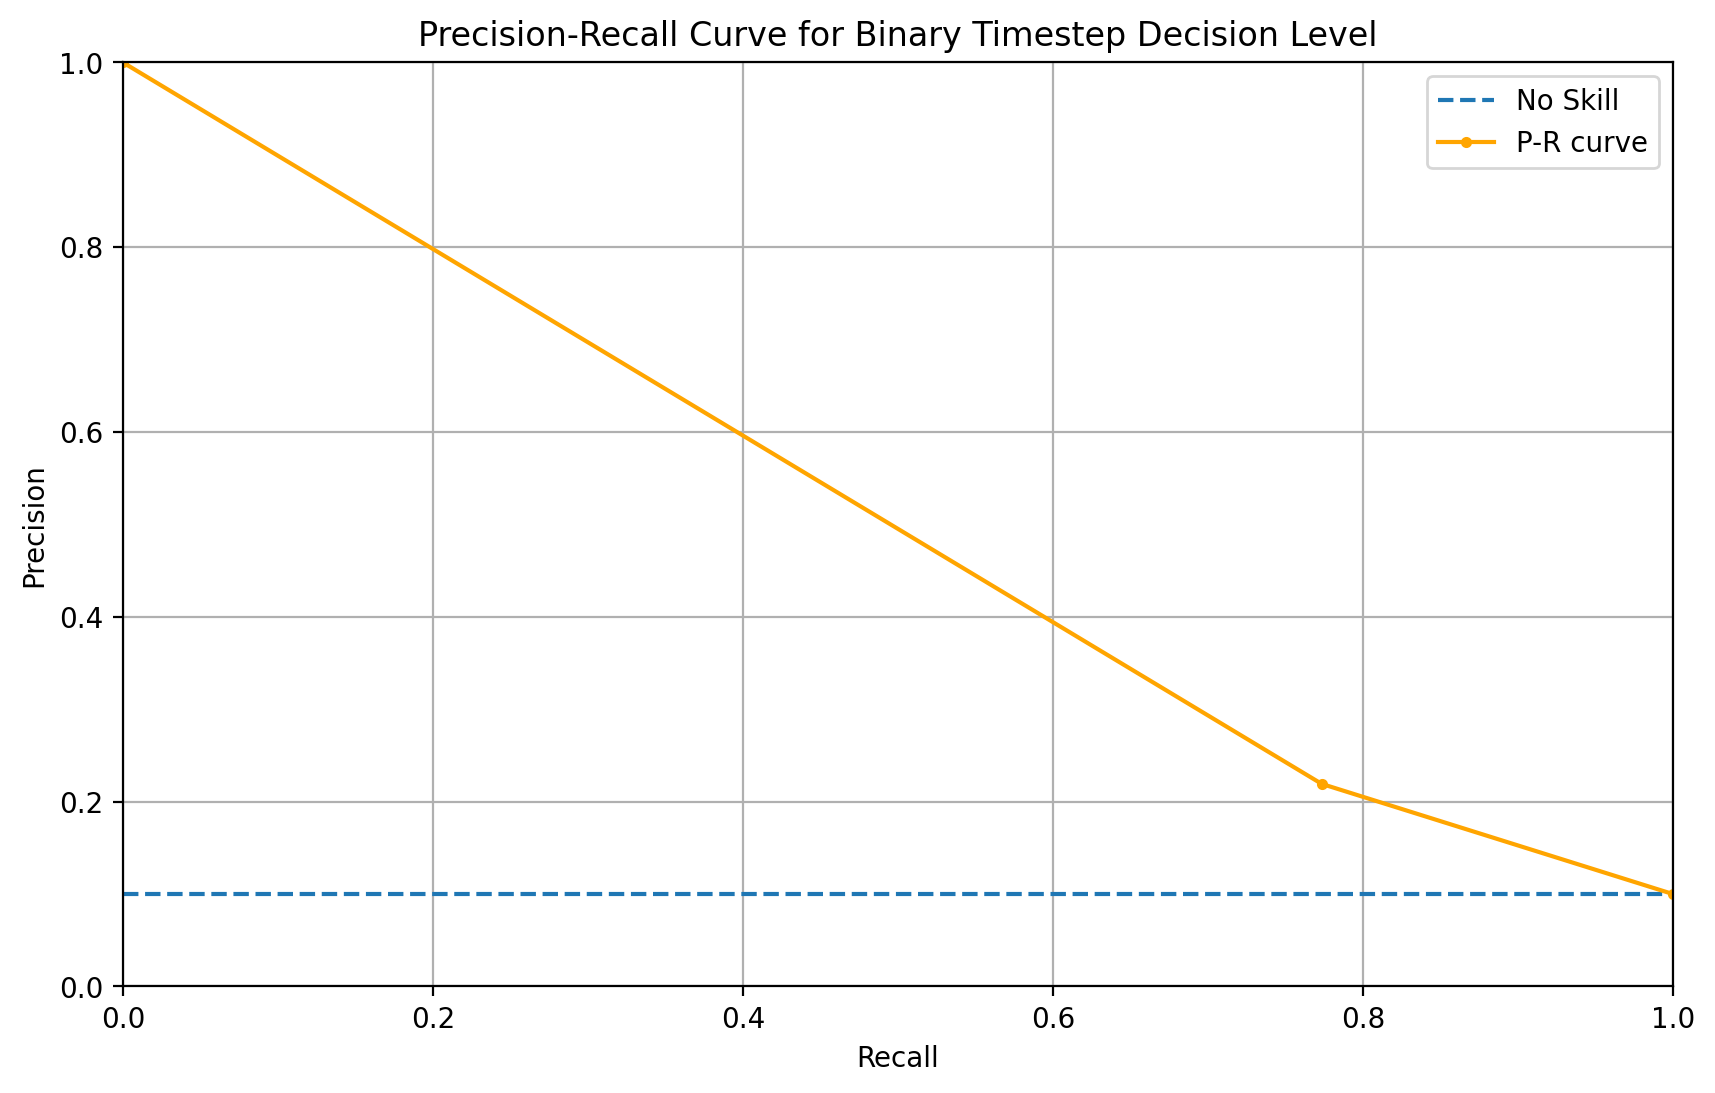

In [98]:
from sklearn.metrics import precision_recall_curve

# Calculate binary anomaly decisions for each timestep
timestep_decisions = binary_anomaly_decisions(corrupted_reconstruction_error_timestep, best_threshold)

# Flatten the timestep decisions and true anomalies to match shapes
timestep_decisions_flat = timestep_decisions.flatten()
true_anomalies_flat = np.repeat(true_anomalies, seq_length)

# Ensure both arrays have the same length
min_len = min(len(true_anomalies_flat), len(timestep_decisions_flat))
true_anomalies_flat = true_anomalies_flat[:min_len]
timestep_decisions_flat = timestep_decisions_flat[:min_len]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_anomalies_flat, timestep_decisions_flat)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
no_skill = len(true_anomalies_flat[true_anomalies_flat==1]) / len(true_anomalies_flat)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', color='orange', label='P-R curve')
plt.title('Precision-Recall Curve for Binary Timestep Decision Level')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

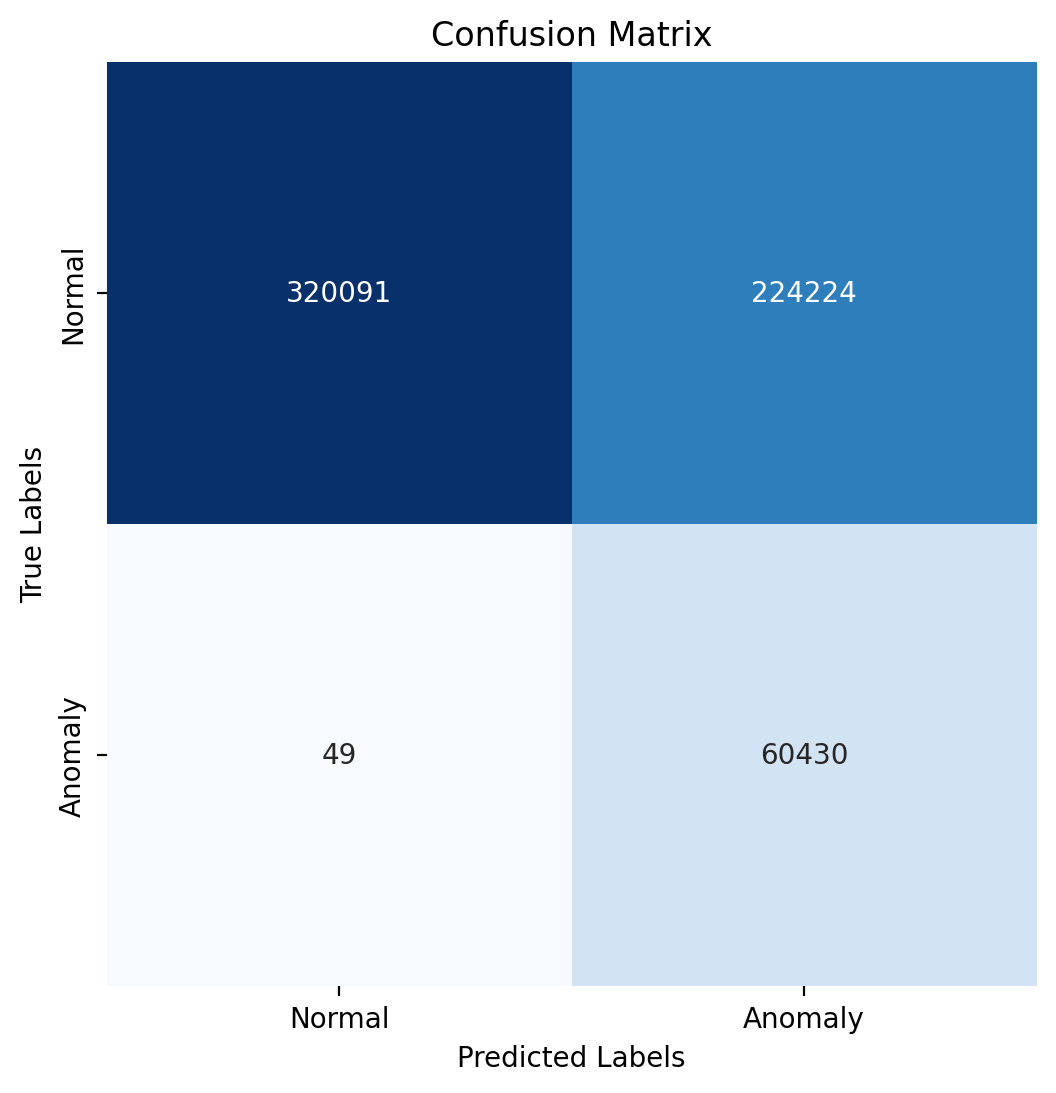

In [99]:
threshold=best_threshold
true_anomalies = corrupted_data['Target'].values.flatten().astype(int)
predicted_anomalies = (corrupted_reconstruction_error > threshold).astype(int)
min_len = min(len(true_anomalies), len(predicted_anomalies))
true_anomalies = true_anomalies[:min_len]
predicted_anomalies= predicted_anomalies[:min_len]
# Plot confusion matrix
plot_confusion_matrix(true_anomalies, predicted_anomalies)